In [3]:
#cell 1
import os
import logging
import subprocess
import time
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision import models # Use models from here
import timm # For EfficientNet
import torch.quantization as quantization
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import gradio as gr
from statsmodels.stats.inter_rater import fleiss_kappa
import pandas as pd

# Device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

# Classes
classes = ['Benign', 'InSitu', 'Invasive', 'Normal']
num_classes = len(classes)

# Models and Resolutions for 9 training runs
resolutions = [256, 512, 1024]
model_names = ['mobilenet_v3_small', 'efficientnet_b0', 'shufflenet_v2_x1_0']
input_size = 224 # Hardcoding 224x224 input as per original notebook logic

# Directories
data_raw = 'data/raw/bach/ICIAR2018_BACH_Challenge/Photos'
data_processed = 'data/processed'
models_dir = 'models/fp32'
logs_dir = 'logs'
heatmaps_dir = 'heatmaps'
os.makedirs(data_processed, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(heatmaps_dir, exist_ok=True)

# Global Logging
logging.basicConfig(level=logging.INFO)

Using device: mps


In [7]:
#cell 2
def extract_patches(image_path, patch_size, stride, output_dir, class_name, image_name):
    img = Image.open(image_path)
    img_width, img_height = img.size  # 2048x1536 typically
    patch_count = 0
    for y in range(0, img_height - patch_size + 1, stride):
        for x in range(0, img_width - patch_size + 1, stride):
            patch = img.crop((x, y, x + patch_size, y + patch_size))
            patch_path = os.path.join(output_dir, class_name, f'{image_name}_patch{patch_count}.jpg')
            os.makedirs(os.path.dirname(patch_path), exist_ok=True)
            patch.save(patch_path, 'JPEG', quality=95)
            patch_count += 1

# Process for each class
for class_name in classes:
    class_dir = os.path.join(data_raw, class_name)
    images = [f for f in os.listdir(class_dir) if f.endswith('.tif')]
    train_imgs, test_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.5, random_state=42)
    
    for res in resolutions:
        patches_dir = os.path.join(data_processed, f'patches_{res}')
        stride = res // 2
        for split, imgs in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
            output_dir = os.path.join(patches_dir, split)
            for img in imgs:
                image_path = os.path.join(class_dir, img)
                extract_patches(image_path, res, stride, output_dir, class_name, Path(img).stem)

print('Data processing complete.')

KeyboardInterrupt: 

In [ ]:
#cell 3

import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# --- Definitions from setup cell (needed here) ---
data_processed = 'data/processed'
input_size = 224 # All models will be trained on 224x224 images
# ---

def get_dataloaders(res: int, batch_size: int = 32):
    """
    Creates train, val, and test dataloaders for a given patch resolution (res).
    All images are resized to the global input_size (224x224).
    """
    data_path = os.path.join(data_processed, f'patches_{res}')

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.TrivialAugmentWide(), # Replaced manual augs with a stronger policy
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    if not os.path.exists(data_path):
        print(f"Error: Data path not found: {data_path}")
        print("Please ensure your 'data/processed/patches_{res}' directories exist.")
        return None, None, None

    image_datasets = {
        x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x])
        for x in ['train', 'val', 'test']
    }

    # Set num_workers based on OS for compatibility
    num_workers = 4 if os.name == 'posix' else 0 

    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=num_workers, pin_memory=True)
        for x in ['train', 'val', 'test']
    }

    return dataloaders['train'], dataloaders['val'], dataloaders['test']

In [ ]:
#cell 4
import torch.nn as nn
from torchvision import models
import timm

def load_model(model_name: str, num_classes: int = 4):
    """
    Loads a pretrained model, adds dropout, and replaces its classifier head.
    """
    model = None
    if model_name == 'mobilenet_v3_small':
        model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
        in_features = model.classifier[3].in_features
        # Replace the classifier with a new sequence including dropout
        model.classifier = nn.Sequential(
            model.classifier[0], # Original Linear
            model.classifier[1], # Original Hardswish
            nn.Dropout(p=0.5, inplace=True), # Increased dropout
            nn.Linear(in_features, num_classes) # New final layer
        )

    elif model_name == 'efficientnet_b0':
        # Use timm for efficientnet as in the original notebook
        model = timm.create_model('efficientnet_b0', pretrained=True)
        in_features = model.classifier.in_features
        # Replace classifier with dropout + new linear layer
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True), # Increased dropout
            nn.Linear(in_features, num_classes)
        )

    elif model_name == 'shufflenet_v2_x1_0':
        model = models.shufflenet_v2_x1_0(weights='IMAGENET1K_V1')
        in_features = model.fc.in_features
        # Replace the final 'fc' layer with a sequence: dropout + linear
        model.fc = nn.Sequential(
            nn.Dropout(p=0.5), # Increased dropout
            nn.Linear(in_features, num_classes)
        )

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model.to(device)

In [ ]:
#cell 5
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt
import os

# --- Definitions from setup cell (needed here) ---
base_dir = os.getcwd()
models_dir = os.path.join(base_dir, "models", "fp32")
logs_dir = os.path.join(base_dir, "logs")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# ---

def run_training_job(model_name: str, patch_res: int, num_epochs=50):
    """
    Runs a complete training and validation job for a given model and patch resolution.
    """
    
    # 1. Setup paths and logger
    run_id = f"{model_name}_patch{patch_res}"
    checkpoint_path = os.path.join(models_dir, f'model_{run_id}.pth')
    log_file = os.path.join(logs_dir, f'training_{run_id}.log')
    plot_path = os.path.join(logs_dir, f'training_{run_id}_plot.png')

    patience = 10 # Early stopping patience

    # Robust Logger Setup
    logger = logging.getLogger(run_id)
    logger.setLevel(logging.INFO) 

    if logger.hasHandlers():
        logger.handlers.clear()

    fh = logging.FileHandler(log_file, mode='w') # Overwrite log each time
    fh.setLevel(logging.INFO)
    fh.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
    logger.addHandler(fh)

    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter(f'[{model_name} | Res {patch_res}] - %(message)s'))
    logger.addHandler(ch)

    logger.propagate = False
    # END Logger Setup 

    print(f"\n{'='*20} STARTING: {model_name} on {patch_res}x{patch_res} patches {'='*20}")
    logger.info(f'Starting training on {device} with patience={patience}')

    # 2. Load Model and Dataloaders
    model = load_model(model_name)
    train_loader, val_loader, _ = get_dataloaders(patch_res)
    
    if train_loader is None:
        logger.error(f"Failed to get dataloaders for resolution {patch_res}. Skipping training.")
        return

    # 3. Setup Training Components 
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # Added label smoothing
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4) # Increased weight decay
    
    try:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    except TypeError:
        logger.warning("verbose=True not supported in ReduceLROnPlateau. Continuing without it.")
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    start_epoch = 0
    best_val_acc = 0.0
    epochs_no_improve = 0 

    history = {
        'train_loss': [], 'train_acc': [], 'train_precision': [],
        'val_loss': [], 'val_acc': [], 'val_precision': []
    }

    # 4. Training Loop
    # Note: Not loading checkpoints to ensure 9 fresh trainings.
    
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)
        train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=0)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(train_acc)
        history['train_precision'].append(train_precision)

        # Validation
        model.eval()
        running_val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)

        scheduler.step(epoch_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        logger.info(
            f'Epoch {epoch}/{num_epochs-1} | LR: {current_lr:.1e} | '
            f'Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}, Train Prec: {train_precision:.4f} | '
            f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Prec: {val_precision:.4f}'
        )

        for handler in logger.handlers:
            if isinstance(handler, logging.FileHandler):
                handler.flush()

        # Early Stopping Logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0 
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'best_val_acc': best_val_acc
            }, checkpoint_path)
            logger.info(f'New best model saved to {checkpoint_path} with accuracy {val_acc:.4f}')
        else:
            epochs_no_improve += 1
            logger.info(f'No improvement on validation accuracy for {epochs_no_improve} epoch(s). Patience: {patience}.')

        if epochs_no_improve >= patience:
            logger.info(f'Early stopping triggered after {patience} epochs with no improvement.')
            break 
            
    # 5. Plotting
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'Loss ({run_id})')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title(f'Accuracy ({run_id})')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(history['train_precision'], label='Train Precision (Macro)')
    plt.plot(history['val_precision'], label='Val Precision (Macro)')
    plt.title(f'Precision ({run_id})')
    plt.xlabel('Epoch'); plt.ylabel('Precision'); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.savefig(plot_path)
    logger.info(f'Saved training plot to {plot_path}')
    plt.close()

In [17]:
#cell 6
run_training_job('mobilenet_v3_small', 256)

[mobilenet_v3_small | Res 256] - Starting training on mps with patience=10



==================== STARTING: mobilenet_v3_small on 256x256 patches ====================


[mobilenet_v3_small | Res 256] - verbose=True not supported in ReduceLROnPlateau. Continuing without it.
[mobilenet_v3_small | Res 256] - Epoch 0/49 | LR: 1.0e-03 | Train Loss: 0.8342, Train Acc: 0.7401, Train Prec: 0.7404 | Val Loss: 0.8084, Val Acc: 0.7561, Val Prec: 0.7695
[mobilenet_v3_small | Res 256] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_mobilenet_v3_small_patch256.pth with accuracy 0.7561
[mobilenet_v3_small | Res 256] - Epoch 1/49 | LR: 1.0e-03 | Train Loss: 0.6637, Train Acc: 0.8401, Train Prec: 0.8404 | Val Loss: 0.8436, Val Acc: 0.7497, Val Prec: 0.7656
[mobilenet_v3_small | Res 256] - No improvement on validation accuracy for 1 epoch(s). Patience: 10.
[mobilenet_v3_small | Res 256] - Epoch 2/49 | LR: 1.0e-03 | Train Loss: 0.6058, Train Acc: 0.8727, Train Prec: 0.8729 | Val Loss: 0.7978, Val Acc: 0.7738, Val Prec: 0.7814
[mobilenet_v3_small | Res 256] - New best model saved to /Users/vishwaraj/Documents/project/bach-

In [18]:
#cell 7
run_training_job('efficientnet_b0', 256)

[efficientnet_b0 | Res 256] - Starting training on mps with patience=10
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)



==================== STARTING: efficientnet_b0 on 256x256 patches ====================


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
[efficientnet_b0 | Res 256] - verbose=True not supported in ReduceLROnPlateau. Continuing without it.
[efficientnet_b0 | Res 256] - Epoch 0/49 | LR: 1.0e-03 | Train Loss: 0.7936, Train Acc: 0.7621, Train Prec: 0.7622 | Val Loss: 0.8345, Val Acc: 0.7639, Val Prec: 0.7770
[efficientnet_b0 | Res 256] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_efficientnet_b0_patch256.pth with accuracy 0.7639
[efficientnet_b0 | Res 256] - Epoch 1/49 | LR: 1.0e-03 | Train Loss: 0.6281, Train Acc: 0.8583, Train Prec: 0.8584 | Val Loss: 0.7444, Val Acc: 0.8094, Val Prec: 0.8185
[efficientnet_b0 | Res 256] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_efficientnet_b0_patch256.pth with accuracy 0.8094
[efficientnet_b0 | Res 256] - Epoch 2/49 | LR

In [19]:
#cell 8
run_training_job('shufflenet_v2_x1_0', 256)

[shufflenet_v2_x1_0 | Res 256] - Starting training on mps with patience=10



==================== STARTING: shufflenet_v2_x1_0 on 256x256 patches ====================


[shufflenet_v2_x1_0 | Res 256] - verbose=True not supported in ReduceLROnPlateau. Continuing without it.
[shufflenet_v2_x1_0 | Res 256] - Epoch 0/49 | LR: 1.0e-03 | Train Loss: 0.8785, Train Acc: 0.7083, Train Prec: 0.7084 | Val Loss: 0.7980, Val Acc: 0.7675, Val Prec: 0.7696
[shufflenet_v2_x1_0 | Res 256] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_shufflenet_v2_x1_0_patch256.pth with accuracy 0.7675
[shufflenet_v2_x1_0 | Res 256] - Epoch 1/49 | LR: 1.0e-03 | Train Loss: 0.7185, Train Acc: 0.8056, Train Prec: 0.8055 | Val Loss: 0.7814, Val Acc: 0.7672, Val Prec: 0.7651
[shufflenet_v2_x1_0 | Res 256] - No improvement on validation accuracy for 1 epoch(s). Patience: 10.
[shufflenet_v2_x1_0 | Res 256] - Epoch 2/49 | LR: 1.0e-03 | Train Loss: 0.6640, Train Acc: 0.8401, Train Prec: 0.8402 | Val Loss: 0.8211, Val Acc: 0.7652, Val Prec: 0.7665
[shufflenet_v2_x1_0 | Res 256] - No improvement on validation accuracy for 2 epoch(s). Patience: 

In [20]:
#cell 9
run_training_job('mobilenet_v3_small', 512)

[mobilenet_v3_small | Res 512] - Starting training on mps with patience=10



==================== STARTING: mobilenet_v3_small on 512x512 patches ====================


[mobilenet_v3_small | Res 512] - verbose=True not supported in ReduceLROnPlateau. Continuing without it.
[mobilenet_v3_small | Res 512] - Epoch 0/49 | LR: 1.0e-03 | Train Loss: 0.8875, Train Acc: 0.7037, Train Prec: 0.7031 | Val Loss: 0.6658, Val Acc: 0.8505, Val Prec: 0.8540
[mobilenet_v3_small | Res 512] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_mobilenet_v3_small_patch512.pth with accuracy 0.8505
[mobilenet_v3_small | Res 512] - Epoch 1/49 | LR: 1.0e-03 | Train Loss: 0.6702, Train Acc: 0.8381, Train Prec: 0.8382 | Val Loss: 0.7059, Val Acc: 0.8157, Val Prec: 0.8237
[mobilenet_v3_small | Res 512] - No improvement on validation accuracy for 1 epoch(s). Patience: 10.
[mobilenet_v3_small | Res 512] - Epoch 2/49 | LR: 1.0e-03 | Train Loss: 0.6011, Train Acc: 0.8784, Train Prec: 0.8782 | Val Loss: 0.6931, Val Acc: 0.8305, Val Prec: 0.8330
[mobilenet_v3_small | Res 512] - No improvement on validation accuracy for 2 epoch(s). Patience: 

In [22]:
#cell 10
run_training_job('efficientnet_b0', 512)

[efficientnet_b0 | Res 512] - Starting training on mps with patience=10
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)



==================== STARTING: efficientnet_b0 on 512x512 patches ====================


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
[efficientnet_b0 | Res 512] - verbose=True not supported in ReduceLROnPlateau. Continuing without it.
[efficientnet_b0 | Res 512] - Epoch 0/49 | LR: 1.0e-03 | Train Loss: 0.8112, Train Acc: 0.7558, Train Prec: 0.7556 | Val Loss: 0.6675, Val Acc: 0.8448, Val Prec: 0.8444
[efficientnet_b0 | Res 512] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_efficientnet_b0_patch512.pth with accuracy 0.8448
[efficientnet_b0 | Res 512] - Epoch 1/49 | LR: 1.0e-03 | Train Loss: 0.6352, Train Acc: 0.8591, Train Prec: 0.8590 | Val Loss: 0.9172, Val Acc: 0.7490, Val Prec: 0.7898
[efficientnet_b0 | Res 512] - No improvement on validation accuracy for 1 epoch(s). Patience: 10.
[efficientnet_b0 | Res 512] - Epoch 2/49 | LR: 1.0e-03 | Train Loss: 0.5769, Train Acc: 0.8849, Train Prec: 0.8849 | Val L

In [23]:
#cell 11
run_training_job('shufflenet_v2_x1_0', 512)

[shufflenet_v2_x1_0 | Res 512] - Starting training on mps with patience=10



==================== STARTING: shufflenet_v2_x1_0 on 512x512 patches ====================


[shufflenet_v2_x1_0 | Res 512] - verbose=True not supported in ReduceLROnPlateau. Continuing without it.
[shufflenet_v2_x1_0 | Res 512] - Epoch 0/49 | LR: 1.0e-03 | Train Loss: 0.9284, Train Acc: 0.6856, Train Prec: 0.6850 | Val Loss: 0.8428, Val Acc: 0.7362, Val Prec: 0.7522
[shufflenet_v2_x1_0 | Res 512] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_shufflenet_v2_x1_0_patch512.pth with accuracy 0.7362
[shufflenet_v2_x1_0 | Res 512] - Epoch 1/49 | LR: 1.0e-03 | Train Loss: 0.7126, Train Acc: 0.8135, Train Prec: 0.8134 | Val Loss: 0.7445, Val Acc: 0.7905, Val Prec: 0.8049
[shufflenet_v2_x1_0 | Res 512] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_shufflenet_v2_x1_0_patch512.pth with accuracy 0.7905
[shufflenet_v2_x1_0 | Res 512] - Epoch 2/49 | LR: 1.0e-03 | Train Loss: 0.6550, Train Acc: 0.8432, Train Prec: 0.8432 | Val Loss: 0.7850, Val Acc: 0.7790, Val Prec: 0.7907
[shufflenet_v2_x1

In [24]:
#cell 12
run_training_job('mobilenet_v3_small', 1024)

[mobilenet_v3_small | Res 1024] - Starting training on mps with patience=10
[mobilenet_v3_small | Res 1024] - verbose=True not supported in ReduceLROnPlateau. Continuing without it.



==================== STARTING: mobilenet_v3_small on 1024x1024 patches ====================


[mobilenet_v3_small | Res 1024] - Epoch 0/49 | LR: 1.0e-03 | Train Loss: 1.0294, Train Acc: 0.6185, Train Prec: 0.6177 | Val Loss: 1.0337, Val Acc: 0.6694, Val Prec: 0.7214
[mobilenet_v3_small | Res 1024] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_mobilenet_v3_small_patch1024.pth with accuracy 0.6694
[mobilenet_v3_small | Res 1024] - Epoch 1/49 | LR: 1.0e-03 | Train Loss: 0.7368, Train Acc: 0.7935, Train Prec: 0.7934 | Val Loss: 1.0148, Val Acc: 0.6889, Val Prec: 0.7746
[mobilenet_v3_small | Res 1024] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_mobilenet_v3_small_patch1024.pth with accuracy 0.6889
[mobilenet_v3_small | Res 1024] - Epoch 2/49 | LR: 1.0e-03 | Train Loss: 0.6268, Train Acc: 0.8774, Train Prec: 0.8771 | Val Loss: 1.0657, Val Acc: 0.7194, Val Prec: 0.8207
[mobilenet_v3_small | Res 1024] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/mode

In [25]:
#cell 13
run_training_job('efficientnet_b0', 1024)

[efficientnet_b0 | Res 1024] - Starting training on mps with patience=10
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)



==================== STARTING: efficientnet_b0 on 1024x1024 patches ====================


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
[efficientnet_b0 | Res 1024] - verbose=True not supported in ReduceLROnPlateau. Continuing without it.
[efficientnet_b0 | Res 1024] - Epoch 0/49 | LR: 1.0e-03 | Train Loss: 0.8844, Train Acc: 0.7119, Train Prec: 0.7113 | Val Loss: 0.7008, Val Acc: 0.8556, Val Prec: 0.8736
[efficientnet_b0 | Res 1024] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_efficientnet_b0_patch1024.pth with accuracy 0.8556
[efficientnet_b0 | Res 1024] - Epoch 1/49 | LR: 1.0e-03 | Train Loss: 0.6167, Train Acc: 0.8667, Train Prec: 0.8665 | Val Loss: 0.5951, Val Acc: 0.9028, Val Prec: 0.9087
[efficientnet_b0 | Res 1024] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_efficientnet_b0_patch1024.pth with accuracy 0.9028
[efficientnet_b0 | Res 1024] - Epoch 2

In [26]:
#cell 14
run_training_job('shufflenet_v2_x1_0', 1024)

[shufflenet_v2_x1_0 | Res 1024] - Starting training on mps with patience=10



==================== STARTING: shufflenet_v2_x1_0 on 1024x1024 patches ====================


[shufflenet_v2_x1_0 | Res 1024] - verbose=True not supported in ReduceLROnPlateau. Continuing without it.
[shufflenet_v2_x1_0 | Res 1024] - Epoch 0/49 | LR: 1.0e-03 | Train Loss: 1.2047, Train Acc: 0.5565, Train Prec: 0.5647 | Val Loss: 0.8541, Val Acc: 0.7250, Val Prec: 0.7550
[shufflenet_v2_x1_0 | Res 1024] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_shufflenet_v2_x1_0_patch1024.pth with accuracy 0.7250
[shufflenet_v2_x1_0 | Res 1024] - Epoch 1/49 | LR: 1.0e-03 | Train Loss: 0.8501, Train Acc: 0.7375, Train Prec: 0.7378 | Val Loss: 0.7835, Val Acc: 0.7972, Val Prec: 0.8111
[shufflenet_v2_x1_0 | Res 1024] - New best model saved to /Users/vishwaraj/Documents/project/bach-project copy/models/fp32/model_shufflenet_v2_x1_0_patch1024.pth with accuracy 0.7972
[shufflenet_v2_x1_0 | Res 1024] - Epoch 2/49 | LR: 1.0e-03 | Train Loss: 0.7021, Train Acc: 0.8280, Train Prec: 0.8277 | Val Loss: 0.7178, Val Acc: 0.8361, Val Prec: 0.8514
[shufflen

In [8]:
#cell 15
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Check required variables from Cell 1
try:
    _ = logs_dir
    _ = model_names
    _ = resolutions
except NameError:
    print("Error: Required variables (logs_dir, model_names, resolutions) not defined.")
    print("Please ensure Cell 1 has been run.")
    # Define fallbacks in case cell 1 wasn't run
    logs_dir = 'logs'
    model_names = ['mobilenet_v3_small', 'efficientnet_b0', 'shufflenet_v2_x1_0']
    resolutions = [256, 512, 1024]

print("--- Starting Re-generation of Training Plots from Log Files ---")

def parse_log_file(log_path):
    """Parses a training log file and returns a history dictionary."""
    
    # Regex to capture the 6 metrics + epoch
    log_pattern = re.compile(
        r"Epoch (\d+)/\d+.*?Train Loss: ([0-9.]+), Train Acc: ([0-9.]+), Train Prec: ([0-9.]+)"
        r".*?Val Loss: ([0-9.]+), Val Acc: ([0-9.]+), Val Prec: ([0-9.]+)"
    )
    
    history = {
        'epoch': [],
        'train_loss': [], 'train_acc': [], 'train_precision': [],
        'val_loss': [], 'val_acc': [], 'val_precision': []
    }
    
    try:
        with open(log_path, 'r') as f:
            for line in f:
                match = log_pattern.search(line)
                if match:
                    try:
                        history['epoch'].append(int(match.group(1)))
                        history['train_loss'].append(float(match.group(2)))
                        history['train_acc'].append(float(match.group(3)))
                        history['train_precision'].append(float(match.group(4)))
                        history['val_loss'].append(float(match.group(5)))
                        history['val_acc'].append(float(match.group(6)))
                        history['val_precision'].append(float(match.group(7)))
                    except (ValueError, IndexError) as e:
                        print(f"  Warning: Skipping malformed line in {log_path}: {line.strip()} ({e})")
    except FileNotFoundError:
        print(f"  Error: Log file not found at {log_path}")
        return None
    except Exception as e:
        print(f"  Error reading log file {log_path}: {e}")
        return None
        
    if not history['epoch']:
         print(f"  Warning: No metrics found in {log_path}. Was training completed?")
         return None
         
    return history

def plot_metrics_from_history(history_dict, run_id, plot_path):
    """Generates and saves a 3-panel plot from a history dictionary with new styling."""
    
    try:
        # Convert to DataFrame for easier plotting
        df = pd.DataFrame(history_dict)
        
        plt.figure(figsize=(20, 6))
        
        # --- 1. Loss Plot ---
        ax1 = plt.subplot(1, 3, 1)
        ax1.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o', linewidth=2)
        ax1.plot(df['epoch'], df['val_loss'], label='Val Loss', marker='o', linewidth=2)
        ax1.set_title(f'Loss ({run_id})')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_xlim(left=0) # Start X axis at 0
        ax1.set_ylim(bottom=0) # Start Y axis at 0
        ax1.legend()
        ax1.grid(True)
        
        # --- 2. Accuracy Plot ---
        ax2 = plt.subplot(1, 3, 2)
        ax2.plot(df['epoch'], df['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
        ax2.plot(df['epoch'], df['val_acc'], label='Val Accuracy', marker='o', linewidth=2)
        ax2.set_title(f'Accuracy ({run_id})')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlim(left=0) # Start X axis at 0
        ax2.set_ylim(bottom=0) # Start Y axis at 0
        ax2.legend()
        ax2.grid(True)
        
        # --- 3. Precision Plot ---
        ax3 = plt.subplot(1, 3, 3)
        ax3.plot(df['epoch'], df['train_precision'], label='Train Precision (Macro)', marker='o', linewidth=2)
        ax3.plot(df['epoch'], df['val_precision'], label='Val Precision (Macro)', marker='o', linewidth=2)
        ax3.set_title(f'Precision ({run_id})')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Precision')
        ax3.set_xlim(left=0) # Start X axis at 0
        ax3.set_ylim(bottom=0) # Start Y axis at 0
        ax3.legend()
        ax3.grid(True)
        
        # --- Save Figure ---
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.close() # Close the figure to free up memory
        
        print(f"  Successfully saved new plot to: {plot_path}")
        
    except Exception as e:
        print(f"  Error plotting for {run_id}: {e}")
        if 'history_dict' in locals() and history_dict:
            print(f"  Data keys available: {history_dict.keys()}")
        plt.close() # Ensure plot is closed even on error

# --- Main Loop ---
# Suppress the UserWarning from Matplotlib about using a non-GUI backend to save plots
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

for model_name in model_names:
    for res in resolutions:
        run_id = f"{model_name}_patch{res}"
        log_file = os.path.join(logs_dir, f'training_{run_id}.log')
        # Save with a new name (e.g., _v2) to avoid overwriting original plots
        new_plot_path = os.path.join(logs_dir, f'training_{run_id}_plot_v2.png')
        
        print(f"\nProcessing: {run_id}")
        
        if os.path.exists(log_file):
            history_data = parse_log_file(log_file)
            if history_data:
                plot_metrics_from_history(history_data, run_id, new_plot_path)
        else:
            print(f"  Log file not found, skipping: {log_file}")

# Reset warnings
warnings.filterwarnings("default", category=UserWarning, module="matplotlib")
print("\n--- Plot Re-generation Complete ---")

--- Starting Re-generation of Training Plots from Log Files ---

Processing: mobilenet_v3_small_patch256
  Successfully saved new plot to: logs/training_mobilenet_v3_small_patch256_plot_v2.png

Processing: mobilenet_v3_small_patch512
  Successfully saved new plot to: logs/training_mobilenet_v3_small_patch512_plot_v2.png

Processing: mobilenet_v3_small_patch1024
  Successfully saved new plot to: logs/training_mobilenet_v3_small_patch1024_plot_v2.png

Processing: efficientnet_b0_patch256
  Successfully saved new plot to: logs/training_efficientnet_b0_patch256_plot_v2.png

Processing: efficientnet_b0_patch512
  Successfully saved new plot to: logs/training_efficientnet_b0_patch512_plot_v2.png

Processing: efficientnet_b0_patch1024
  Successfully saved new plot to: logs/training_efficientnet_b0_patch1024_plot_v2.png

Processing: shufflenet_v2_x1_0_patch256
  Successfully saved new plot to: logs/training_shufflenet_v2_x1_0_patch256_plot_v2.png

Processing: shufflenet_v2_x1_0_patch512
  Succ

In [ ]:
#cell 16
import os
import logging
import subprocess
import time
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from statsmodels.stats.inter_rater import fleiss_kappa
import pandas as pd

# --- Definitions from setup cell (needed here) ---
classes = ['Benign', 'InSitu', 'Invasive', 'Normal']
raw_test_dir = 'data/raw/bach/ICIAR2018_BACH_Challenge/Photos'
# ---

def compute_fleiss_kappa(df_ratings):
    """
    Computes Fleiss' Kappa for inter-pathologist agreement.
    """
    try:
        n_categories = len(classes)
        n_subjects = len(df_ratings)
        count_matrix = np.zeros((n_subjects, n_categories))

        for i, (idx, row) in enumerate(df_ratings.iterrows()):
            pathologist_ratings = row.filter(regex='^p[0-9]+').values
            for rating in pathologist_ratings:
                if pd.notna(rating) and 0 <= rating < n_categories:
                    count_matrix[i, int(rating)] += 1
        
        # Add 'method' argument for compatibility with newer statsmodels
        return fleiss_kappa(count_matrix, method='fleiss')
    except Exception as e:
        print(f"Error computing Fleiss' Kappa: {e}")
        return np.nan

def generate_proxy_ground_truth(csv_path='ground_truth_regions.csv', raw_dir=raw_test_dir):
    """
    Generates proxy bounding boxes for IoU calculation.
    """
    print(f"Generating proxy ground truth regions at {csv_path}...")
    test_images = []
    for class_name in classes:
        class_dir = os.path.join(raw_dir, class_name)
        if not os.path.exists(class_dir): continue
        images = [f for f in os.listdir(class_dir) if f.endswith('.tif')]
        if not images: continue
        _, val_test = train_test_split(images, test_size=0.3, random_state=42)
        _, test = train_test_split(val_test, test_size=0.5, random_state=42)
        test_images.extend([os.path.join(class_dir, img) for img in test])
    
    data = []
    for img_path in test_images:
        img = Image.open(img_path)
        w, h = img.size
        data.append({
            'image_id': Path(img_path).name,
            'x_min': 0.3, 'y_min': 0.3,
            'x_max': 0.7, 'y_max': 0.7
        })
    
    df = pd.DataFrame(data)
    df.to_csv(csv_path, index=False)
    print(f"Proxy ground truth saved to {csv_path} with {len(df)} entries.")

def generate_enhanced_proxy_ratings(csv_path='pathologist_scores.csv', raw_dir=raw_test_dir):
    """
    Generates proxy pathologist ratings for agreement analysis.
    """
    print(f"Generating enhanced proxy ratings at {csv_path}...")
    test_images = []
    for class_name in classes:
        class_dir = os.path.join(raw_dir, class_name)
        if not os.path.exists(class_dir): continue
        images = [f for f in os.listdir(class_dir) if f.endswith('.tif')]
        if not images: continue
        _, val_test = train_test_split(images, test_size=0.3, random_state=42)
        _, test = train_test_split(val_test, test_size=0.5, random_state=42)
        test_images.extend([os.path.join(class_dir, img) for img in test])
    
    image_ids = [Path(p).name for p in test_images]
    df = pd.DataFrame({'image_id': image_ids})

    # Simulate ratings
    for idx, row in df.iterrows():
        img_path = [p for p in test_images if Path(p).name == row['image_id']][0]
        true_label = classes.index(Path(img_path).parent.name)
        df.at[idx, 'p1'] = true_label
        df.at[idx, 'p2'] = true_label if np.random.random() < 0.8 else (true_label + np.random.choice([-1, 1])) % 4
        df.at[idx, 'p3'] = true_label if np.random.random() < 0.6 else (true_label + np.random.choice([-1, 1])) % 4
    
    df.to_csv(csv_path, index=False)
    print(f"Enhanced proxy ratings saved to {csv_path}")
    
    ratings_df = df.filter(regex='^p[0-9]+')
    kappa = compute_fleiss_kappa(ratings_df)
    print(f"Updated Fleiss’ Kappa: {kappa:.4f}")

# Run the helper functions to generate proxy data if they don't exist
if not os.path.exists('ground_truth_regions.csv'):
    generate_proxy_ground_truth()
if not os.path.exists('pathologist_scores.csv'):
    generate_enhanced_proxy_ratings()

In [ ]:
#cell 17
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import os

# Definitions from setup cell (needed here)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
models_dir = 'models/fp32'
classes = ['Benign', 'InSitu', 'Invasive', 'Normal']
model_names = ['mobilenet_v3_small', 'efficientnet_b0', 'shufflenet_v2_x1_0']
resolutions = [256, 512, 1024]

print(f"--- Starting Performance Evaluation on Test Set ---")
print(f"Using device: {device}\n")

# To store summary metrics for the final table
performance_summary = []

# Iterate over all 9 combinations
for model_name in model_names:
    for res in resolutions:
        run_id = f"{model_name}_patch{res}"
        print(f"\n{'='*20} EVALUATING: {model_name} on {res}x{res} patches {'='*20}")
        
        model_path = os.path.join(models_dir, f'model_{run_id}.pth')
        
        if not os.path.exists(model_path):
            print(f"Model file not found, skipping: {model_path}")
            performance_summary.append({
                "Model": model_name,
                "Resolution": res,
                "Accuracy": "N/A",
                "F1-Macro": "N/A",
                "Precision-Macro": "N/A",
                "Recall-Macro": "N/A"
            })
            continue

        #1. Load Model
        try:
            model = load_model(model_name) # From Cell 4
            # Load the saved state dict
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device) # Move to device (e.g., MPS or CUDA)
            model.eval()
        except Exception as e:
            print(f"Error loading model {model_path}: {e}")
            continue

        # 2. Load Test Data
        try:
            _, _, test_loader = get_dataloaders(res) # From Cell 3
            if test_loader is None:
                raise Exception(f"Dataloader for res {res} was not created.")
        except Exception as e:
            print(f"Error loading data for res {res}: {e}")
            continue

        # 3. Run Inference
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        if not all_labels:
            print("No data found in test loader.")
            continue
            
        # 4. Calculate and Print Metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        print(f"--- Metrics for {run_id} ---")
        print(f"Overall Accuracy: {accuracy:.4f}\n")
        print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))
        
        # Store for summary table
        performance_summary.append({
            "Model": model_name,
            "Resolution": res,
            "Accuracy": accuracy,
            "F1-Macro": f1_macro,
            "Precision-Macro": precision_macro,
            "Recall-Macro": recall_macro
        })

print("\n--- Evaluation Complete ---")

--- Starting Performance Evaluation on Test Set ---
Using device: mps


==================== EVALUATING: mobilenet_v3_small on 256x256 patches ====================


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


--- Metrics for mobilenet_v3_small_patch256 ---
Overall Accuracy: 0.8118

              precision    recall  f1-score   support

      Benign       0.76      0.82      0.79      2475
      InSitu       0.81      0.77      0.79      2475
    Invasive       0.84      0.81      0.82      2475
      Normal       0.84      0.86      0.85      2475

    accuracy                           0.81      9900
   macro avg       0.81      0.81      0.81      9900
weighted avg       0.81      0.81      0.81      9900


==================== EVALUATING: mobilenet_v3_small on 512x512 patches ====================


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


--- Metrics for mobilenet_v3_small_patch512 ---
Overall Accuracy: 0.8424

              precision    recall  f1-score   support

      Benign       0.81      0.85      0.83       525
      InSitu       0.87      0.80      0.84       525
    Invasive       0.86      0.83      0.84       525
      Normal       0.83      0.90      0.86       525

    accuracy                           0.84      2100
   macro avg       0.84      0.84      0.84      2100
weighted avg       0.84      0.84      0.84      2100


==================== EVALUATING: mobilenet_v3_small on 1024x1024 patches ====================


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


--- Metrics for mobilenet_v3_small_patch1024 ---
Overall Accuracy: 0.8861

              precision    recall  f1-score   support

      Benign       0.85      0.89      0.87        90
      InSitu       0.83      0.88      0.85        90
    Invasive       0.93      0.88      0.90        90
      Normal       0.94      0.90      0.92        90

    accuracy                           0.89       360
   macro avg       0.89      0.89      0.89       360
weighted avg       0.89      0.89      0.89       360


==================== EVALUATING: efficientnet_b0 on 256x256 patches ====================


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


--- Metrics for efficientnet_b0_patch256 ---
Overall Accuracy: 0.8546

              precision    recall  f1-score   support

      Benign       0.83      0.84      0.83      2475
      InSitu       0.90      0.78      0.84      2475
    Invasive       0.85      0.93      0.89      2475
      Normal       0.85      0.87      0.86      2475

    accuracy                           0.85      9900
   macro avg       0.86      0.85      0.85      9900
weighted avg       0.86      0.85      0.85      9900


==================== EVALUATING: efficientnet_b0 on 512x512 patches ====================


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


--- Metrics for efficientnet_b0_patch512 ---
Overall Accuracy: 0.8695

              precision    recall  f1-score   support

      Benign       0.87      0.82      0.84       525
      InSitu       0.90      0.85      0.87       525
    Invasive       0.83      0.87      0.85       525
      Normal       0.88      0.95      0.91       525

    accuracy                           0.87      2100
   macro avg       0.87      0.87      0.87      2100
weighted avg       0.87      0.87      0.87      2100


==================== EVALUATING: efficientnet_b0 on 1024x1024 patches ====================


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


--- Metrics for efficientnet_b0_patch1024 ---
Overall Accuracy: 0.8639

              precision    recall  f1-score   support

      Benign       0.79      0.80      0.80        90
      InSitu       0.85      0.87      0.86        90
    Invasive       0.84      0.88      0.86        90
      Normal       0.99      0.91      0.95        90

    accuracy                           0.86       360
   macro avg       0.87      0.86      0.86       360
weighted avg       0.87      0.86      0.86       360


==================== EVALUATING: shufflenet_v2_x1_0 on 256x256 patches ====================


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


--- Metrics for shufflenet_v2_x1_0_patch256 ---
Overall Accuracy: 0.7968

              precision    recall  f1-score   support

      Benign       0.80      0.77      0.79      2475
      InSitu       0.80      0.76      0.78      2475
    Invasive       0.78      0.83      0.80      2475
      Normal       0.81      0.83      0.82      2475

    accuracy                           0.80      9900
   macro avg       0.80      0.80      0.80      9900
weighted avg       0.80      0.80      0.80      9900


==================== EVALUATING: shufflenet_v2_x1_0 on 512x512 patches ====================


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


--- Metrics for shufflenet_v2_x1_0_patch512 ---
Overall Accuracy: 0.8410

              precision    recall  f1-score   support

      Benign       0.84      0.82      0.83       525
      InSitu       0.87      0.79      0.83       525
    Invasive       0.83      0.85      0.84       525
      Normal       0.82      0.90      0.86       525

    accuracy                           0.84      2100
   macro avg       0.84      0.84      0.84      2100
weighted avg       0.84      0.84      0.84      2100


==================== EVALUATING: shufflenet_v2_x1_0 on 1024x1024 patches ====================


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


--- Metrics for shufflenet_v2_x1_0_patch1024 ---
Overall Accuracy: 0.7806

              precision    recall  f1-score   support

      Benign       0.65      0.89      0.75        90
      InSitu       0.90      0.71      0.80        90
    Invasive       0.83      0.72      0.77        90
      Normal       0.82      0.80      0.81        90

    accuracy                           0.78       360
   macro avg       0.80      0.78      0.78       360
weighted avg       0.80      0.78      0.78       360


--- Evaluation Complete ---


In [ ]:
#cell 18
import pandas as pd

print("\n--- Performance Metrics Summary Table ---")

if 'performance_summary' in locals() and performance_summary:
    df = pd.DataFrame(performance_summary)
    
    # Format floating point numbers
    float_cols = ['Accuracy', 'F1-Macro', 'Precision-Macro', 'Recall-Macro']
    for col in float_cols:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)
            
    print(df.to_markdown(index=False))
else:
    print("Performance summary data not found. Please run Cell 16 first.")


--- Performance Metrics Summary Table ---
| Model              |   Resolution |   Accuracy |   F1-Macro |   Precision-Macro |   Recall-Macro |
|:-------------------|-------------:|-----------:|-----------:|------------------:|---------------:|
| mobilenet_v3_small |          256 |     0.8118 |     0.8118 |            0.8127 |         0.8118 |
| mobilenet_v3_small |          512 |     0.8424 |     0.8422 |            0.8437 |         0.8424 |
| mobilenet_v3_small |         1024 |     0.8861 |     0.8867 |            0.8885 |         0.8861 |
| efficientnet_b0    |          256 |     0.8546 |     0.854  |            0.8563 |         0.8546 |
| efficientnet_b0    |          512 |     0.8695 |     0.869  |            0.8702 |         0.8695 |
| efficientnet_b0    |         1024 |     0.8639 |     0.8648 |            0.8669 |         0.8639 |
| shufflenet_v2_x1_0 |          256 |     0.7968 |     0.7965 |            0.7971 |         0.7968 |
| shufflenet_v2_x1_0 |          512 |     0.841 

In [7]:
#cell 19
import pandas as pd
import torch
import os
from sklearn.metrics import classification_report
import warnings

# Ensure required functions/vars from other cells are available
# These are defined in Cell 1, 3, and 4
try:
    _ = device
    _ = models_dir
    _ = classes
    _ = model_names
    _ = resolutions
    _ = get_dataloaders
    _ = load_model
except NameError:
    print("Error: Required variables (device, models_dir, etc.) or functions (get_dataloaders, load_model) not defined.")
    print("Please ensure Cells 1, 3, and 4 have been run before this cell.")

print("--- Starting Per-Class Performance Evaluation on Test Set ---")

# To store summary metrics for the per-class table
per_class_summary = []

# Suppress warnings from classification_report for classes with 0 support in preds
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Iterate over all 9 combinations
for model_name in model_names:
    for res in resolutions:
        run_id = f"{model_name}_patch{res}"
        print(f"Evaluating: {run_id}...")
        
        model_path = os.path.join(models_dir, f'model_{run_id}.pth')
        
        if not os.path.exists(model_path):
            print(f"  Model file not found, skipping: {model_path}")
            continue

        # 1. Load Model
        try:
            model = load_model(model_name) # From Cell 4
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device)
            model.eval()
        except Exception as e:
            print(f"  Error loading model {model_path}: {e}")
            continue

        # 2. Load Test Data
        try:
            _, _, test_loader = get_dataloaders(res) # From Cell 3
            if test_loader is None:
                raise Exception(f"Dataloader for res {res} was not created.")
        except Exception as e:
            print(f"  Error loading data for res {res}: {e}")
            continue

        # 3. Run Inference
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        if not all_labels:
            print("  No data found in test loader.")
            continue
            
        # 4. Calculate Metrics as Dictionary
        report_dict = classification_report(
            all_labels, 
            all_preds, 
            target_names=classes, 
            output_dict=True, 
            zero_division=0
        )
        
        # 5. Store Per-Class Metrics
        for class_name in classes:
            if class_name in report_dict:
                metrics = report_dict[class_name]
                per_class_summary.append({
                    "Model": model_name,
                    "Resolution": res,
                    "Class": class_name,
                    "Precision": metrics['precision'],
                    "Recall": metrics['recall'],
                    "F1-Score": metrics['f1-score'],
                    "Support": metrics['support']
                })
        
        # Add a separator row for clarity in the final table
        per_class_summary.append({
            "Model": "---", "Resolution": "---", "Class": "---", 
            "Precision": "---", "Recall": "---", "F1-Score": "---", "Support": "---"
        })

print("\n" + "="*40)
print("--- Per-Class Performance Metrics Summary ---")
print("="*40 + "\n")

if per_class_summary:
    # Remove the last separator
    per_class_summary.pop()
    
    df_class = pd.DataFrame(per_class_summary)
    
    # Format floating point numbers
    float_cols = ['Precision', 'Recall', 'F1-Score']
    for col in float_cols:
        df_class[col] = df_class[col].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)
            
    print(df_class.to_markdown(index=False))
else:
    print("Per-class summary data could not be generated.")

print("\n--- Per-Class Evaluation Complete ---")

# Reset warnings
warnings.filterwarnings('default', category=UserWarning, module='sklearn')

--- Starting Per-Class Performance Evaluation on Test Set ---
Evaluating: mobilenet_v3_small_patch256...


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluating: mobilenet_v3_small_patch512...


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluating: mobilenet_v3_small_patch1024...


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


Evaluating: efficientnet_b0_patch256...


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


Evaluating: efficientnet_b0_patch512...


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


Evaluating: efficientnet_b0_patch1024...


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluating: shufflenet_v2_x1_0_patch256...


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluating: shufflenet_v2_x1_0_patch512...


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluating: shufflenet_v2_x1_0_patch1024...


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Per-Class Performance Metrics Summary ---

| Model              | Resolution   | Class    | Precision   | Recall   | F1-Score   | Support   |
|:-------------------|:-------------|:---------|:------------|:---------|:-----------|:----------|
| mobilenet_v3_small | 256          | Benign   | 0.7647      | 0.8154   | 0.7892     | 2475.0    |
| mobilenet_v3_small | 256          | InSitu   | 0.8054      | 0.7661   | 0.7853     | 2475.0    |
| mobilenet_v3_small | 256          | Invasive | 0.8423      | 0.8053   | 0.8234     | 2475.0    |
| mobilenet_v3_small | 256          | Normal   | 0.8383      | 0.8606   | 0.8493     | 2475.0    |
| ---                | ---          | ---      | ---         | ---      | ---        | ---       |
| mobilenet_v3_small | 512          | Benign   | 0.8132      | 0.8457   | 0.8291     | 525.0     |
| mobilenet_v3_small | 512          | InSitu   | 0.8716      | 0.8019   | 0.8353     | 525.0     |
| mobilenet_v3_small | 512          | Invasive | 0.8594      

In [ ]:
#cell 20
import torch
import os
import copy

# Definitions from setup cell (needed here)
model_names = ['mobilenet_v3_small', 'efficientnet_b0', 'shufflenet_v2_x1_0']
resolutions = [256, 512, 1024]
models_dir = 'models/fp32'
models_fp16_dir = 'models/fp16'
# Use the main device, as MPS/CUDA supports FP16
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 4
# ---

os.makedirs(models_fp16_dir, exist_ok=True)
print(f"Starting FP16 conversion for all 9 models. Saving to: {models_fp16_dir}")
print(f"Using device: {device}")

if device.type == 'cpu':
    print("Warning: CPU does not natively support FP16 compute. Models will be loaded but may run slower or revert to FP32.")

for model_name in model_names:
    for res in resolutions:
        run_id = f"{model_name}_patch{res}"
        fp32_model_path = os.path.join(models_dir, f'model_{run_id}.pth')
        fp16_model_path = os.path.join(models_fp16_dir, f'model_{run_id}_fp16.pth')
        
        print(f"\nProcessing: {run_id}")
        
        if not os.path.exists(fp32_model_path):
            print(f"  Skipping: FP32 model not found at {fp32_model_path}")
            continue
            
        try:
            # 1. Load FP32 model structure and weights
            model_fp32 = load_model(model_name, num_classes) # load_model is from cell 4
            model_fp32.to(device)
            
            checkpoint = torch.load(fp32_model_path, map_location=device)
            model_fp32.load_state_dict(checkpoint['model_state_dict'])
            model_fp32.eval()
            
            # 2. Convert to FP16
            if device.type != 'cpu':
                model_fp16 = model_fp32.half()
            else:
                model_fp16 = model_fp32 # Store as FP32 if on CPU
            
            # 3. Save the FP16 model
            # We save the full model, not just the state_dict,
            # as it's simpler for this conversion.
            torch.save(model_fp16, fp16_model_path)
            
            print(f"  Successfully converted to FP16 and saved to {fp16_model_path}")

        except Exception as e:
            print(f"  FAILED to convert {run_id} to FP16. Error: {e}")

print("\nFP16 conversion complete for all models.")

Starting FP16 conversion for all 9 models. Saving to: models/fp16
Using device: mps

Processing: mobilenet_v3_small_patch256
  Successfully converted to FP16 and saved to models/fp16/model_mobilenet_v3_small_patch256_fp16.pth

Processing: mobilenet_v3_small_patch512
  Successfully converted to FP16 and saved to models/fp16/model_mobilenet_v3_small_patch512_fp16.pth

Processing: mobilenet_v3_small_patch1024


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


  Successfully converted to FP16 and saved to models/fp16/model_mobilenet_v3_small_patch1024_fp16.pth

Processing: efficientnet_b0_patch256


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


  Successfully converted to FP16 and saved to models/fp16/model_efficientnet_b0_patch256_fp16.pth

Processing: efficientnet_b0_patch512


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


  Successfully converted to FP16 and saved to models/fp16/model_efficientnet_b0_patch512_fp16.pth

Processing: efficientnet_b0_patch1024


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


  Successfully converted to FP16 and saved to models/fp16/model_efficientnet_b0_patch1024_fp16.pth

Processing: shufflenet_v2_x1_0_patch256
  Successfully converted to FP16 and saved to models/fp16/model_shufflenet_v2_x1_0_patch256_fp16.pth

Processing: shufflenet_v2_x1_0_patch512
  Successfully converted to FP16 and saved to models/fp16/model_shufflenet_v2_x1_0_patch512_fp16.pth

Processing: shufflenet_v2_x1_0_patch1024
  Successfully converted to FP16 and saved to models/fp16/model_shufflenet_v2_x1_0_patch1024_fp16.pth

FP16 conversion complete for all models.


In [ ]:
#cell 21
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Definitions from setup cell (needed here)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
models_dir = 'models/fp32'
models_fp16_dir = 'models/fp16'
logs_dir = 'logs'
classes = ['Benign', 'InSitu', 'Invasive', 'Normal']
num_classes = len(classes)
model_names = ['mobilenet_v3_small', 'efficientnet_b0', 'shufflenet_v2_x1_0']
resolutions = [256, 512, 1024]

print("--- Starting Confusion Matrix Generation for all 18 models ---")
os.makedirs(logs_dir, exist_ok=True)

for model_name in model_names:
    for res in resolutions:
        for precision in ['fp32', 'fp16']:
            
            run_id = f"{model_name}_patch{res}"
            print(f"\nProcessing: {run_id} ({precision})")
            
            model = None
            
            # 1. Load Model
            try:
                if precision == 'fp32':
                    model_path = os.path.join(models_dir, f'model_{run_id}.pth')
                    if not os.path.exists(model_path):
                        print(f"  Skipping: FP32 model not found at {model_path}")
                        continue
                    model = load_model(model_name, num_classes) # From Cell 4
                    checkpoint = torch.load(model_path, map_location=device)
                    model.load_state_dict(checkpoint['model_state_dict'])
                
                else: # fp16
                    model_path = os.path.join(models_fp16_dir, f'model_{run_id}_fp16.pth')
                    if not os.path.exists(model_path):
                        print(f"  Skipping: FP16 model not found at {model_path}")
                        continue
                    
                    # FIX: Added weights_only=False
                    model = torch.load(model_path, map_location=device, weights_only=False) 
                
                model.to(device).eval()

            except Exception as e:
                print(f"  Error loading model {run_id} ({precision}): {e}")
                continue

            # 2. Load Test Data
            try:
                # Assuming get_dataloaders is defined in a previous cell
                _, _, test_loader = get_dataloaders(res) # From Cell 3
                if test_loader is None:
                    raise Exception(f"Test dataloader for res {res} was not found.")
            except Exception as e:
                print(f"  Error loading data: {e}")
                continue

            # 3. Run Inference
            all_labels = []
            all_preds = []
            
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    # Convert input to FP16 if model is FP16
                    if precision == 'fp16' and device.type != 'cpu':
                        inputs = inputs.half() 
                        
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

            if not all_labels:
                print("  Skipping: No data found in test loader.")
                continue

            # 4. Calculate and Plot Confusion Matrix
            try:
                cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
                df_cm = pd.DataFrame(cm, index=classes, columns=classes)
                
                plt.figure(figsize=(10, 7))
                sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
                plt.title(f'Confusion Matrix - {run_id} ({precision})', fontsize=16)
                plt.xlabel('Predicted Label', fontsize=12)
                plt.ylabel('True Label', fontsize=12)
                plt.tight_layout()
                
                # Save the figure
                cm_path = os.path.join(logs_dir, f'cm_{run_id}_{precision}.png')
                plt.savefig(cm_path)
                plt.close() # Close the plot to free memory
                
                print(f"  Successfully generated and saved CM to: {cm_path}")

            except Exception as e:
                print(f"  Error generating plot: {e}")

print("\n--- Confusion Matrix Generation Complete ---")

--- Starting Confusion Matrix Generation for all 18 models ---

Processing: mobilenet_v3_small_patch256 (fp32)
  Successfully generated and saved CM to: logs/cm_mobilenet_v3_small_patch256_fp32.png

Processing: mobilenet_v3_small_patch256 (fp16)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_mobilenet_v3_small_patch256_fp16.png

Processing: mobilenet_v3_small_patch512 (fp32)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_mobilenet_v3_small_patch512_fp32.png

Processing: mobilenet_v3_small_patch512 (fp16)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_mobilenet_v3_small_patch512_fp16.png

Processing: mobilenet_v3_small_patch1024 (fp32)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_mobilenet_v3_small_patch1024_fp32.png

Processing: mobilenet_v3_small_patch1024 (fp16)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


  Successfully generated and saved CM to: logs/cm_mobilenet_v3_small_patch1024_fp16.png

Processing: efficientnet_b0_patch256 (fp32)


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_efficientnet_b0_patch256_fp32.png

Processing: efficientnet_b0_patch256 (fp16)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


  Successfully generated and saved CM to: logs/cm_efficientnet_b0_patch256_fp16.png

Processing: efficientnet_b0_patch512 (fp32)


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_efficientnet_b0_patch512_fp32.png

Processing: efficientnet_b0_patch512 (fp16)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)


  Successfully generated and saved CM to: logs/cm_efficientnet_b0_patch512_fp16.png

Processing: efficientnet_b0_patch1024 (fp32)


INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_efficientnet_b0_patch1024_fp32.png

Processing: efficientnet_b0_patch1024 (fp16)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_efficientnet_b0_patch1024_fp16.png

Processing: shufflenet_v2_x1_0_patch256 (fp32)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_shufflenet_v2_x1_0_patch256_fp32.png

Processing: shufflenet_v2_x1_0_patch256 (fp16)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_shufflenet_v2_x1_0_patch256_fp16.png

Processing: shufflenet_v2_x1_0_patch512 (fp32)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_shufflenet_v2_x1_0_patch512_fp32.png

Processing: shufflenet_v2_x1_0_patch512 (fp16)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_shufflenet_v2_x1_0_patch512_fp16.png

Processing: shufflenet_v2_x1_0_patch1024 (fp32)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_shufflenet_v2_x1_0_patch1024_fp32.png

Processing: shufflenet_v2_x1_0_patch1024 (fp16)


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Successfully generated and saved CM to: logs/cm_shufflenet_v2_x1_0_patch1024_fp16.png

--- Confusion Matrix Generation Complete ---


In [ ]:
#cell 22
import os
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split

# Ensure class_names is defined (from setup)
class_names = ['Benign', 'InSitu', 'Invasive', 'Normal']
raw_test_dir = 'data/raw/bach/ICIAR2018_BACH_Challenge/Photos'

def generate_proxy_ground_truth(csv_path='ground_truth_regions.csv', raw_dir=raw_test_dir):
    print(f"Generating proxy ground truth regions at {csv_path}...")
    test_images = []
    for class_name in class_names:
        class_dir = os.path.join(raw_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found {class_dir}")
            continue
        images = [f for f in os.listdir(class_dir) if f.endswith('.tif')]
        if not images:
            print(f"Warning: No images found in {class_dir}")
            continue
        
        # Ensure at least 2 samples for split
        if len(images) < 2:
            test = images
        else:
            _, val_test = train_test_split(images, test_size=0.3, random_state=42)
            if len(val_test) < 2:
                test = val_test
            else:
                _, test = train_test_split(val_test, test_size=0.5, random_state=42)
        
        test_images.extend([os.path.join(class_dir, img) for img in test])

    print(f"Found {len(test_images)} test images for proxy data.")
    
    # Simulate bounding boxes: central region (30–70% of image width/height)
    data = []
    for img_path in test_images:
        try:
            with Image.open(img_path) as img:
                w, h = img.size
            x_min = 0.3  # Normalized coordinates
            y_min = 0.3
            x_max = 0.7
            y_max = 0.7
            data.append({
                'image_id': Path(img_path).name,
                'x_min': x_min, 'y_min': y_min,
                'x_max': x_max, 'y_max': y_max
            })
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
    
    df = pd.DataFrame(data)
    df.to_csv(csv_path, index=False)
    print(f"Proxy ground truth saved to {csv_path} with {len(df)} entries.")

if not os.path.exists('ground_truth_regions.csv'):
    generate_proxy_ground_truth()
else:
    print("ground_truth_regions.csv already exists.")

Generating proxy ground truth regions at ground_truth_regions.csv...
Found 60 test images for proxy data.
Proxy ground truth saved to ground_truth_regions.csv with 60 entries.


In [ ]:
#cell 23
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import os
from statsmodels.stats.inter_rater import fleiss_kappa

# Ensure class_names and raw_test_dir are defined
class_names = ['Benign', 'InSitu', 'Invasive', 'Normal']
num_classes = len(class_names)
raw_test_dir = 'data/raw/bach/ICIAR2018_BACH_Challenge/Photos'

def compute_fleiss_kappa(df_ratings):
    """
    Computes Fleiss' Kappa for inter-pathologist agreement.
    (From original Cell 14)
    """
    try:
        n_categories = num_classes
        n_subjects = len(df_ratings)
        # Filter for columns starting with 'p' followed by a digit
        pathologist_cols = df_ratings.filter(regex='^p[0-9]+').columns
        if pathologist_cols.empty:
            print("Warning: No pathologist columns (p1, p2, ...) found.")
            return np.nan
            
        count_matrix = np.zeros((n_subjects, n_categories))

        for i, (idx, row) in enumerate(df_ratings.iterrows()):
            ratings = row[pathologist_cols].values
            for rating in ratings:
                if pd.notna(rating) and 0 <= int(rating) < n_categories:
                    count_matrix[i, int(rating)] += 1
        
        # Filter out rows with no ratings
        valid_rows = count_matrix.sum(axis=1) > 0
        if not np.any(valid_rows):
            print("Warning: No valid ratings found to compute Fleiss' Kappa.")
            return np.nan
            
        kappa = fleiss_kappa(count_matrix[valid_rows], method='fleiss')
        return kappa
    except Exception as e:
        print(f"Error computing Fleiss' Kappa: {e}")
        return np.nan

def generate_enhanced_proxy_ratings(csv_path='pathologist_scores.csv', gt_csv_path='ground_truth_regions.csv', raw_dir=raw_test_dir):
    """
    Generates enhanced proxy ratings based on the ground truth CSV.
    (From original Cell 8)
    """
    print(f"Generating enhanced proxy ratings at {csv_path}...")
    
    if not os.path.exists(gt_csv_path):
        print(f"Error: {gt_csv_path} not found. Please run proxy ground truth cell first.")
        return
        
    df = pd.read_csv(gt_csv_path) # Read image IDs from GT csv
    
    # Need to find the true label for each test image
    test_images_map = {}
    for class_name in class_names:
        class_dir = os.path.join(raw_dir, class_name)
        if not os.path.exists(class_dir): continue
        images = [f for f in os.listdir(class_dir) if f.endswith('.tif')]
        if not images: continue
        
        if len(images) < 2:
            test = images
        else:
            _, val_test = train_test_split(images, test_size=0.3, random_state=42)
            if len(val_test) < 2:
                test = val_test
            else:
                _, test = train_test_split(val_test, test_size=0.5, random_state=42)
        
        for img_name in test:
            test_images_map[img_name] = class_name

    # Simulate ratings with more variability
    for idx, row in df.iterrows():
        image_name = row['image_id']
        if image_name in test_images_map:
            true_label_name = test_images_map[image_name]
            true_label = class_names.index(true_label_name)
            
            # p1: Agrees with ground truth
            # p2: 80% chance agree, 20% chance off by ±1
            # p3: 60% chance agree, 40% chance off by ±1
            df.at[idx, 'p1'] = true_label
            df.at[idx, 'p2'] = true_label if np.random.random() < 0.8 else (true_label + np.random.choice([-1, 1])) % num_classes
            df.at[idx, 'p3'] = true_label if np.random.random() < 0.6 else (true_label + np.random.choice([-1, 1])) % num_classes
        else:
            print(f"Warning: Image ID {image_name} from GT not found in test split map.")
            df.at[idx, 'p1'] = 0
            df.at[idx, 'p2'] = 0
            df.at[idx, 'p3'] = 0

    df.to_csv(csv_path, index=False)
    print(f"Enhanced proxy ratings saved to {csv_path}")
    
    # Recompute Fleiss’ κ
    kappa = compute_fleiss_kappa(df)
    print(f"Updated Fleiss’ Kappa: {kappa:.4f}")

if not os.path.exists('pathologist_scores.csv'):
    generate_enhanced_proxy_ratings()
else:
    print("pathologist_scores.csv already exists.")

Generating enhanced proxy ratings at pathologist_scores.csv...
Enhanced proxy ratings saved to pathologist_scores.csv
Updated Fleiss’ Kappa: 0.4433


In [ ]:
#cell 24
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch

# Setup Figure
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# 1. WSI Input
ax.add_patch(patches.Rectangle((0.5, 8.5), 1.5, 1.0,
                              fill=True, facecolor='lightblue', edgecolor='black'))
ax.text(1.25, 9.0, 'WSI Input\n(2048x1536)', ha='center', va='center',
        fontsize=10, weight='bold')

# Arrow to patching
ax.add_patch(patches.FancyArrowPatch((1.25, 8.5), (1.75, 7.2),
                                     arrowstyle='->', mutation_scale=20, linewidth=1.5))

# 2. Patching
ax.add_patch(FancyBboxPatch((0.5, 6.0), 2.5, 1.2,
                           boxstyle="round,pad=0.1", facecolor='lightgreen', edgecolor='black'))
ax.text(1.75, 6.6, 'Multi-Res Patching\nStride = res/2', ha='center', va='center', fontsize=10)

# 3. Resolution Branches
res_y = [5.0, 3.5, 2.0]
resolutions_text = [256, 512, 1024]

#: All models are from the SAME family (e.g., MobileNetV3)
models_text = ['MobileNetV3 (256)', 'MobileNetV3 (512)', 'MobileNetV3 (1024)']
# All models have the same color to show they are one family
model_color = '#f4a261' 
colors = [model_color, model_color, model_color] 
legend_patches = [] # For legend

for i, res in enumerate(resolutions_text):
    # Box for Patches
    ax.add_patch(patches.Rectangle((0.5, res_y[i]-0.5), 1.5, 1.0,
                                  fill=True, facecolor='yellow', edgecolor='black'))
    ax.text(1.25, res_y[i], f'{res}x{res} Patches', ha='center', va='center', fontsize=9)

    # Arrow from Patching box to patch boxes
    ax.add_patch(patches.FancyArrowPatch((1.25, 6.0), (1.25, res_y[i]+0.5), # Point to top
                                         arrowstyle='->', mutation_scale=15, linewidth=1.0, color='darkgreen'))

    # Arrow from Patches to Model
    ax.add_patch(patches.FancyArrowPatch((2.0, res_y[i]), (3.0, res_y[i]),
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))

    # Box for CNN Model
    face_color = colors[i]
    model_name = models_text[i]
    ax.add_patch(patches.Rectangle((3.0, res_y[i]-0.5), 2.5, 1.0,
                                  fill=True, facecolor=face_color, alpha=0.85, edgecolor='black'))
    ax.text(4.25, res_y[i], model_name, ha='center', va='center', fontsize=9, weight='bold', color='black')
    
    # Arrow from Model to Feature Convergence
    ax.add_patch(patches.FancyArrowPatch((5.5, res_y[i]), (6.5, 4.0),
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))

# 4. Feature Extraction (Convergence Point)
ax.add_patch(FancyBboxPatch((6.5, 3.5), 2.0, 1.0,
                           boxstyle="round,pad=0.1", facecolor='pink', edgecolor='black'))
ax.text(7.5, 4.0, 'Feature\nVectors', ha='center', va='center', fontsize=10)

# 5. Fusion
ax.add_patch(patches.FancyArrowPatch((7.5, 3.5), (7.5, 2.3),
                                     arrowstyle='->', mutation_scale=20, linewidth=1.5, color='gray'))
ax.add_patch(patches.Circle((7.5, 1.5), 0.8, facecolor='lightcoral', edgecolor='black'))
ax.text(7.5, 1.5, 'MRPE\nFusion\n(Weights)', ha='center', va='center', fontsize=10, weight='bold')

# 6. Output
ax.add_patch(FancyBboxPatch((6.5, 0.0), 2.5, 1.0, boxstyle="round,pad=0.1",
                           fill=True, facecolor='lavender', edgecolor='black'))
ax.text(7.75, 0.5, 'Predictions\n(Probs, Heatmaps)', ha='center', va='center', fontsize=10)

# Arrow from Fusion to Output
ax.add_patch(patches.FancyArrowPatch((7.5, 0.7), (7.75, 1.0),
                                     arrowstyle='->', mutation_scale=20, linewidth=1.5))

# 7. ADD LEGEND
legend_patches.append(patches.Patch(color='lightblue', label='WSI Input'))
legend_patches.append(patches.Patch(color='lightgreen', label='Patching'))
legend_patches.append(patches.Patch(color='yellow', label='Patch Tensors'))
legend_patches.append(patches.Patch(color=model_color, label='CNN Model (Single Family)'))
legend_patches.append(patches.Patch(color='pink', label='Feature Extraction'))
legend_patches.append(patches.Patch(color='lightcoral', label='MRPE Fusion'))
legend_patches.append(patches.Patch(color='lavender', label='Final Output'))

ax.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9, frameon=False)


# Final Touches
# Updated title to be more general
plt.title('Figure 1: MRE-Net Framework for a Single Model Family\n(e.g., MobileNet, EfficientNet, or ShuffleNet)', fontsize=14, weight='bold')
plt.savefig('mre_framework_corrected_logic.png', dpi=300, bbox_inches='tight')
plt.show()

--- Initializing Enhanced Evaluation Suite (18-Model Version) ---
--- Using device: mps ---
--- Loaded 9 FP32 and 9 FP16 models for eval ---

--- Computing mobilenet_v3_small FP32 Weights (MRPE) ---
  Res 256: Acc=0.8242, Time/Img=2.33 ms
  Res 512: Acc=0.8733, Time/Img=4.83 ms
  Res 1024: Acc=0.9306, Time/Img=11.40 ms
Computed Weights (mobilenet_v3_small MRPE): {256: 0.5746036575958308, 512: 0.2930152107239177, 1024: 0.13238113168025165}

--- Computing mobilenet_v3_small FP16 Weights (MRPE) ---
  Res 256: Acc=0.8236, Time/Img=4.20 ms
  Res 512: Acc=0.8733, Time/Img=6.31 ms
  Res 1024: Acc=0.9333, Time/Img=13.37 ms
Computed Weights (mobilenet_v3_small MRPE): {256: 0.48522232823301503, 512: 0.342183353277681, 1024: 0.1725943184893039}

--- Computing mobilenet_v3_small FP32 Weights (ACCURACY) ---
  Res 256: Acc=0.8242, Time/Img=2.26 ms
  Res 512: Acc=0.8733, Time/Img=4.74 ms
  Res 1024: Acc=0.9306, Time/Img=11.29 ms
Computed Weights (mobilenet_v3_small ACCURACY): {256: 0.3136229990199281

2025-11-11 11:52:18,543 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 11:52:18,546 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


--- Evaluation Loop Finished for shufflenet_v2_x1_0 (60/60 images processed) ---

--- FINAL ENHANCED PERFORMANCE RESULTS (mobilenet_v3_small) ---

--- Individual Model Performance (mobilenet_v3_small) ---

--- Resolution 256 ---
  FP32 (Acc): 0.9000 | (F1): 0.8994 | (Lat): 9.37 ms/patch
  FP16 (Acc): 0.9000 | (F1): 0.8994 | (Lat): 79.65 ms/patch
  FP16 Speedup: 0.12x

--- Resolution 512 ---
  FP32 (Acc): 0.9167 | (F1): 0.9160 | (Lat): 9.58 ms/patch
  FP16 (Acc): 0.9167 | (F1): 0.9160 | (Lat): 80.65 ms/patch
  FP16 Speedup: 0.12x

--- Resolution 1024 ---
  FP32 (Acc): 0.9000 | (F1): 0.8994 | (Lat): 11.54 ms/patch
  FP16 (Acc): 0.9000 | (F1): 0.8994 | (Lat): 83.27 ms/patch
  FP16 Speedup: 0.14x

--- Ensemble Performance (mobilenet_v3_small) ---
  --- FP32 Ensembles ---
  MRPE Weights   (Acc): 0.9167
  Accuracy Weights (Acc): 0.9333
  Equal Weights    (Acc): 0.9333
  Best Single FP32 (Res 512): (Acc): 0.9167
  MRPE Ensemble Gain vs Best Single: +0.0000

  --- FP16 Ensembles ---
  MRPE Wei

2025-11-11 12:28:52,625 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 12:28:52,627 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 12:28:52,743 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 12:28:52,745 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Acc without Res 1024: 0.9167
Acc Drop: 0.0167
Resolution contribution plot saved to: /Users/vishwaraj/Documents/project/bach-project copy/logs/resolution_contribution_mobilenet_v3_small.png

--- FINAL ENHANCED PERFORMANCE RESULTS (efficientnet_b0) ---

--- Individual Model Performance (efficientnet_b0) ---

--- Resolution 256 ---
  FP32 (Acc): 0.9500 | (F1): 0.9498 | (Lat): 9.96 ms/patch
  FP16 (Acc): 0.9500 | (F1): 0.9499 | (Lat): 65.91 ms/patch
  FP16 Speedup: 0.15x

--- Resolution 512 ---
  FP32 (Acc): 0.9000 | (F1): 0.8999 | (Lat): 9.27 ms/patch
  FP16 (Acc): 0.9000 | (F1): 0.8999 | (Lat): 65.59 ms/patch
  FP16 Speedup: 0.14x

--- Resolution 1024 ---
  FP32 (Acc): 0.9167 | (F1): 0.9160 | (Lat): 13.15 ms/patch
  FP16 (Acc): 0.9167 | (F1): 0.9160 | (Lat): 66.96 ms/patch
  FP16 Speedup: 0.20x

--- Ensemble Performance (efficientnet_b0) ---
  --- FP32 Ensembles ---
  MRPE Weights   (Acc): 0.9167
  Accuracy Weights (Acc): 0.9167
  Equal Weights    (Acc): 0.9167
  Best Single FP32 (Res 2

2025-11-11 13:19:40,577 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 13:19:40,579 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Acc without Res 1024: 0.9333
Acc Drop: -0.0167
Resolution contribution plot saved to: /Users/vishwaraj/Documents/project/bach-project copy/logs/resolution_contribution_efficientnet_b0.png

--- FINAL ENHANCED PERFORMANCE RESULTS (shufflenet_v2_x1_0) ---

--- Individual Model Performance (shufflenet_v2_x1_0) ---

--- Resolution 256 ---
  FP32 (Acc): 0.8833 | (F1): 0.8841 | (Lat): 7.11 ms/patch
  FP16 (Acc): 0.8833 | (F1): 0.8841 | (Lat): 10.88 ms/patch
  FP16 Speedup: 0.65x

--- Resolution 512 ---
  FP32 (Acc): 0.9167 | (F1): 0.9161 | (Lat): 7.24 ms/patch
  FP16 (Acc): 0.9167 | (F1): 0.9161 | (Lat): 11.08 ms/patch
  FP16 Speedup: 0.65x

--- Resolution 1024 ---
  FP32 (Acc): 0.7500 | (F1): 0.7514 | (Lat): 8.44 ms/patch
  FP16 (Acc): 0.7500 | (F1): 0.7514 | (Lat): 12.40 ms/patch
  FP16 Speedup: 0.68x

--- Ensemble Performance (shufflenet_v2_x1_0) ---
  --- FP32 Ensembles ---
  MRPE Weights   (Acc): 0.8833
  Accuracy Weights (Acc): 0.9000
  Equal Weights    (Acc): 0.9000
  Best Single FP32 

2025-11-11 13:19:40,804 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 13:19:40,809 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


              precision    recall  f1-score   support

      Benign       0.86      0.86      0.86        14
      InSitu       0.85      0.69      0.76        16
    Invasive       0.65      0.79      0.71        14
      Normal       0.94      0.94      0.94        16

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.83      0.82      0.82        60


--- Task 1 (New): Average Patch Uncertainty (Std Dev) (shufflenet_v2_x1_0) ---
  --- Average Uncertainty (FP32) ---
    Res 256: 0.1231
    Res 512: 0.1043
    Res 1024: 0.0659
  --- Average Uncertainty (FP16) ---
    Res 256: 0.1231
    Res 512: 0.1043
    Res 1024: 0.0659

--- Task 2: Interpretability (Grad-CAM IoU) (shufflenet_v2_x1_0) ---
IoU boxplot saved to: /Users/vishwaraj/Documents/project/bach-project copy/logs/iou_boxplot_shufflenet_v2_x1_0.png

--- Mean IoU Scores ---
  Model 256: 0.0300
  Model 512: 0.0580
  Model 1024: 0.1602
  Fused Ensemble: 

2025-11-11 13:37:01,770 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 13:37:01,772 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Acc without Res 1024: 0.9000
Acc Drop: -0.0167
Resolution contribution plot saved to: /Users/vishwaraj/Documents/project/bach-project copy/logs/resolution_contribution_shufflenet_v2_x1_0.png

--- Enhanced Evaluation Suite Complete ---


--- Initializing Heatmap-Pathologist Correlation (18-Model Version) ---
Loading CSV data...
CSV data loaded.
Identifying test images...
Found 60 test images.

--- Running Heatmap Correlation for mobilenet_v3_small ---
Running inference for mobilenet_v3_small...
Finished processing. Correlating data for 60 images.

--- Correlation Results (mobilenet_v3_small) ---
Pearson Correlation: 0.0904 (p-value: 0.4921)
Spearman Correlation: 0.1253 (p-value: 0.3401)


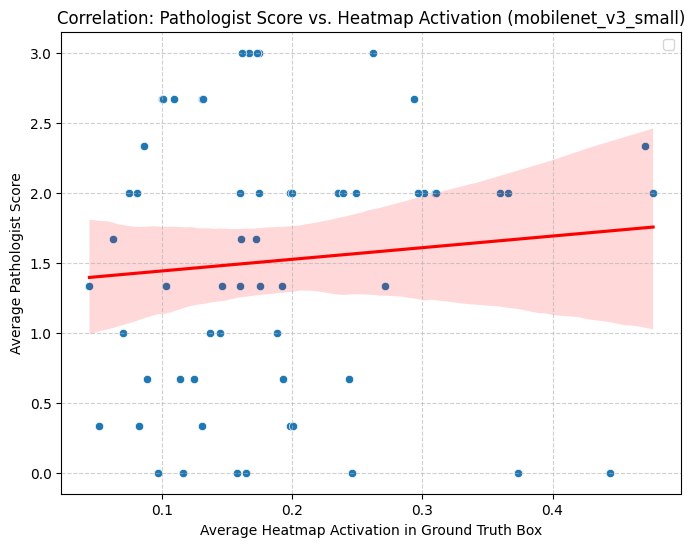


--- Running Heatmap Correlation for efficientnet_b0 ---
Running inference for efficientnet_b0...
Finished processing. Correlating data for 60 images.

--- Correlation Results (efficientnet_b0) ---
Pearson Correlation: 0.2995 (p-value: 0.0201)
Spearman Correlation: 0.3048 (p-value: 0.0179)


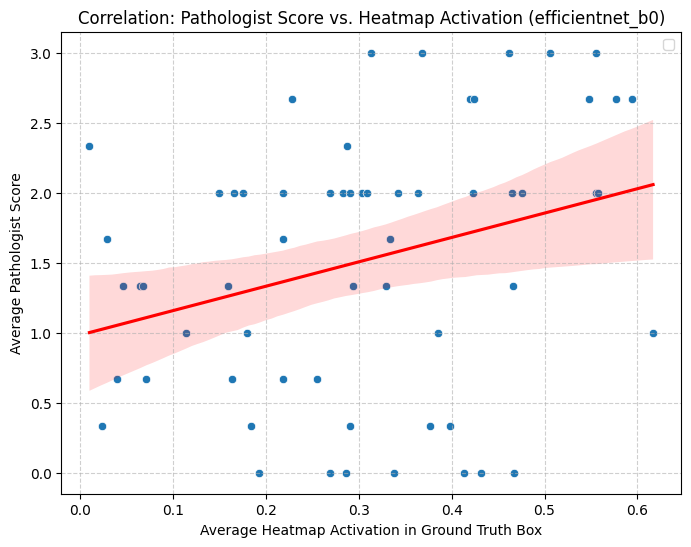


--- Running Heatmap Correlation for shufflenet_v2_x1_0 ---
Running inference for shufflenet_v2_x1_0...
Finished processing. Correlating data for 60 images.

--- Correlation Results (shufflenet_v2_x1_0) ---
Pearson Correlation: 0.2699 (p-value: 0.0370)
Spearman Correlation: 0.2958 (p-value: 0.0217)


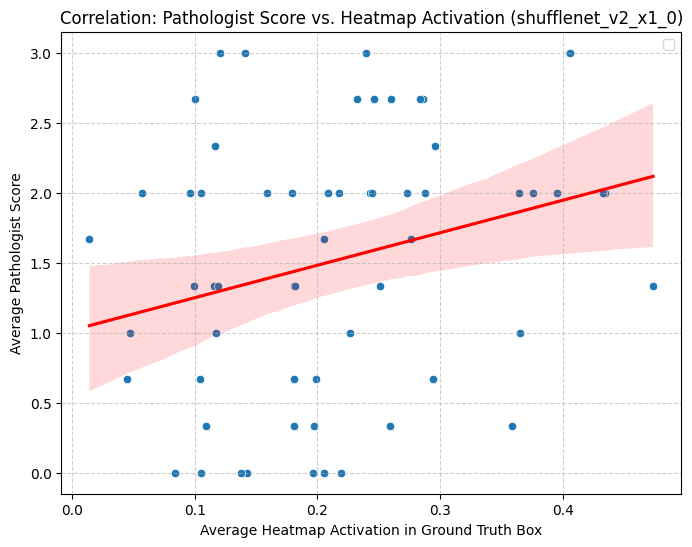

In [ ]:
#cell 25
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import timm
import torchvision
from PIL import Image
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import traceback
import cv2
from torch.amp import autocast
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Re-define key variables and functions

print("--- Initializing Heatmap-Pathologist Correlation (18-Model Version) ---")

# Config
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
resolutions = [256, 512, 1024]
model_families = ['mobilenet_v3_small', 'efficientnet_b0', 'shufflenet_v2_x1_0']
class_names = ['Benign', 'InSitu', 'Invasive', 'Normal']
num_classes = len(class_names)
input_size = 224

# Paths
base_dir = os.getcwd()
models_fp32_dir = os.path.join(base_dir, "models", "fp32")
raw_test_dir = 'data/raw/bach/ICIAR2018_BACH_Challenge/Photos'
gt_csv_path = 'ground_truth_regions.csv'
patho_csv_path = 'pathologist_scores.csv'

# Transform
model_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Helper Functions

def load_model_structure(model_family: str, num_classes: int = 4):
    """ Loads the model *structure* (no weights) - CORRECTLY MATCHES TRAINING CELL 4"""
    model = None
    if model_family == 'mobilenet_v3_small':
        model = models.mobilenet_v3_small(weights=None)
        in_features_final_layer = model.classifier[3].in_features
        original_first_linear = model.classifier[0]
        model.classifier = nn.Sequential(
            original_first_linear, nn.Hardswish(),
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(in_features_final_layer, num_classes)
        )
    elif model_family == 'efficientnet_b0':
        model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
        in_features = model.get_classifier().in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True), 
            nn.Linear(in_features, num_classes)
        )
    elif model_family == 'shufflenet_v2_x1_0':
        model = models.shufflenet_v2_x1_0(weights=None)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(p=0.4), 
            nn.Linear(in_features, num_classes)
        )
    else:
        raise ValueError(f"Unknown model family: {model_family}")
    return model

def get_target_layers(model, model_family):
    try:
        if model_family == 'mobilenet_v3_small': return [model.features[-1]]
        elif model_family == 'efficientnet_b0': return [model.conv_head]
        elif model_family == 'shufflenet_v2_x1_0': return [model.conv5]
    except Exception as e:
        print(f"Error getting target layer: {e}")
        return None

def extract_patches_temp(img: Image.Image, patch_size: int, stride: int):
    patches = []
    img_width, img_height = img.size
    if img_width < patch_size or img_height < patch_size:
        new_size = (max(img_width, patch_size), max(img_height, patch_size))
        img = img.resize(new_size, Image.Resampling.LANCZOS)
        img_width, img_height = new_size
    for y in range(0, img_height - patch_size + 1, stride):
        for x in range(0, img_width - patch_size + 1, stride):
            patch = img.crop((x, y, x + patch_size, y + patch_size))
            patches.append(patch)
    if not patches:
        patch = img.resize((patch_size, patch_size), Image.Resampling.LANCZOS)
        patches.append(patch)
    return patches

def generate_heatmap(model, model_family, input_tensor_fp32, target_class):
    model = model.to(device).eval()
    target_layers = get_target_layers(model, model_family)
    if not target_layers: print(f"ERROR: No target layers found for {model_family}"); return None
    class ModelWrapper(torch.nn.Module):
        def __init__(self, model): super().__init__(); self.model = model.float()
        def forward(self, x): return self.model(x.float())
    model_for_cam = ModelWrapper(model)
    cam = GradCAM(model=model_for_cam, target_layers=target_layers)
    targets = [ClassifierOutputTarget(target_class)]
    try:
        grayscale_cam = cam(input_tensor=input_tensor_fp32.to(device), targets=targets)
        if grayscale_cam is None or len(grayscale_cam) == 0: return None
        cam_result = grayscale_cam[0, :]
        return cv2.normalize(cam_result, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    except Exception as e:
        print(f"ERROR during GradCAM: {e}"); return None

def get_heatmap_activation_in_box(heatmap, gt_box_row):
    if heatmap is None or gt_box_row is None: return np.nan
    try:
        h, w = heatmap.shape
        x_min = max(0, int(gt_box_row['x_min'] * w))
        y_min = max(0, int(gt_box_row['y_min'] * h))
        x_max = min(w, int(gt_box_row['x_max'] * w))
        y_max = min(h, int(gt_box_row['y_max'] * h))
        if y_min >= y_max or x_min >= x_max: return np.nan
        box_region = heatmap[y_min:y_max, x_min:x_max]
        if box_region.size == 0: return np.nan
        return np.mean(box_region)
    except Exception as e:
        print(f"  Error calculating activation in box: {e}"); return np.nan

# Main Correlation Calculation Function
def calculate_heatmap_correlation(model_family, test_image_paths, gt_df, patho_df, all_models_fp32):
    print(f"\n--- Running Heatmap Correlation for {model_family} ---")
    correlation_data = {'image_id': [], 'avg_patho_score': [], 'avg_heatmap_activation': []}

    # 1. Get FP32 models for this family
    models_fp32_fam = {}
    for res in resolutions:
        run_id = f"{model_family}_patch{res}"
        if run_id in all_models_fp32:
            models_fp32_fam[res] = all_models_fp32[run_id]
    if not models_fp32_fam:
        print(f"Error: No FP32 models found for {model_family}. Cannot generate heatmaps.")
        return None

    print(f"Running inference for {model_family}...")
    processed_count = 0
    total_images = len(test_image_paths)
    for idx, img_path in enumerate(test_image_paths):
        image_id = Path(img_path).name
        # print(f"  Processing {idx+1}/{total_images}: {image_id}") # Too verbose, remove

        patho_row = patho_df[patho_df['image_id'] == image_id]
        gt_box_rows = gt_df[gt_df['image_id'] == image_id]
        if patho_row.empty or gt_box_rows.empty: continue
        patho_row = patho_row.iloc[0]
        gt_box_row = gt_box_rows.iloc[0]

        try:
            img = Image.open(img_path).convert("RGB")
            input_tensor_fp32_cam = model_transform(img).unsqueeze(0).to(device).float()

            pathologist_cols = patho_row.filter(regex='^p[0-9]+')
            avg_score = np.nanmean(pd.to_numeric(pathologist_cols.values, errors='coerce'))
            if pd.isna(avg_score): continue

            heatmaps_fp32 = []
            for res in resolutions:
                if res not in models_fp32_fam: continue
                model = models_fp32_fam[res]
                
                # Get model prediction for this image
                with torch.no_grad():
                     patches = extract_patches_temp(img, res, res // 2)
                     if not patches: continue
                     patch_probs = []
                     for patch in patches:
                         patch_tensor = model_transform(patch).unsqueeze(0).to(device)
                         with autocast(device_type=device.type, enabled=False):
                              output = model(patch_tensor)
                         patch_probs.append(torch.softmax(output, 1).cpu().numpy())
                     avg_prob = np.mean(patch_probs, axis=0).flatten()
                     pred_idx = np.argmax(avg_prob)

                hm = generate_heatmap(model, model_family, input_tensor_fp32_cam, pred_idx)
                if hm is not None:
                    heatmaps_fp32.append(hm)

            if not heatmaps_fp32: continue

            fused_hm = np.mean(heatmaps_fp32, axis=0)
            avg_activation = get_heatmap_activation_in_box(fused_hm, gt_box_row)
            if pd.isna(avg_activation): continue

            correlation_data['image_id'].append(image_id)
            correlation_data['avg_patho_score'].append(avg_score)
            correlation_data['avg_heatmap_activation'].append(avg_activation)
            processed_count += 1

        except Exception as e:
            print(f"!!! FAILED processing image {image_id} for correlation: {e}")
            traceback.print_exc()

    print(f"Finished processing. Correlating data for {processed_count} images.")
    return pd.DataFrame(correlation_data)


# Execute Correlation Analysis
if __name__ == "__main__":
    try:
        print("Loading CSV data...")
        gt_df = pd.read_csv(gt_csv_path)
        patho_df = pd.read_csv(patho_csv_path)
        print("CSV data loaded.")

        print("Identifying test images...")
        test_image_paths = []
        for class_name in class_names:
            class_dir = os.path.join(raw_test_dir, class_name)
            if not os.path.exists(class_dir): continue
            images = [f for f in os.listdir(class_dir) if f.endswith('.tif')]
            if not images: continue
            if len(images) < 2: test = images
            else:
                _, val_test = train_test_split(images, test_size=0.3, random_state=42)
                if len(val_test) < 2: test = val_test
                else: _, test = train_test_split(val_test, test_size=0.5, random_state=42)
            test_image_paths.extend([os.path.join(class_dir, img) for img in test])

        if not test_image_paths:
             raise ValueError("No test images found.")
        print(f"Found {len(test_image_paths)} test images.")

        # Check if models exist (should be loaded by previous cell, if run)
        if 'g_models_fp32' not in globals() or not g_models_fp32:
             print("Warning: Global model cache not found. Loading models now...")
             g_models_fp32, _ = load_all_models_for_eval() # Need the loading function defined
             if not g_models_fp32:
                  raise ValueError("Failed to load FP32 models. Cannot proceed.")
        
        # Run analysis for each model family
        for family in model_families:
            correlation_df = calculate_heatmap_correlation(family, test_image_paths, gt_df, patho_df, g_models_fp32)

            if correlation_df is not None and not correlation_df.empty:
                scores = correlation_df['avg_patho_score']
                activations = correlation_df['avg_heatmap_activation']
                
                if len(scores) < 2:
                    print(f"Insufficient data for correlation for {family}")
                    continue

                pearson_corr, pearson_p = pearsonr(scores, activations)
                spearman_corr, spearman_p = spearmanr(scores, activations)

                print(f"\n--- Correlation Results ({family}) ---")
                print(f"Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_p:.4f})")
                print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4f})")

                # Plotting
                plt.figure(figsize=(8, 6))
                sns.scatterplot(x='avg_heatmap_activation', y='avg_patho_score', data=correlation_df)
                # ADDED LEGEND
                sns.regplot(x='avg_heatmap_activation', y='avg_patho_score', data=correlation_df, scatter=False, color='red', line_kws={'label':f'Pearson R={pearson_corr:.3f}'})
                plt.title(f'Correlation: Pathologist Score vs. Heatmap Activation ({family})')
                plt.xlabel('Average Heatmap Activation in Ground Truth Box')
                plt.ylabel('Average Pathologist Score')
                plt.legend() # ADDED
                plt.grid(True, linestyle='--', alpha=0.6)
                plt.savefig(os.path.join(logs_dir, f'correlation_plot_{family}.png'))
                plt.show()

            else:
                print(f"Correlation analysis failed or produced no data for {family}.")

    except NameError as ne:
         print(f"NameError: A required variable or function is not defined: {ne}")
    except FileNotFoundError as fnf:
         print(f"FileNotFoundError: Required CSV file not found: {fnf}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        traceback.print_exc()

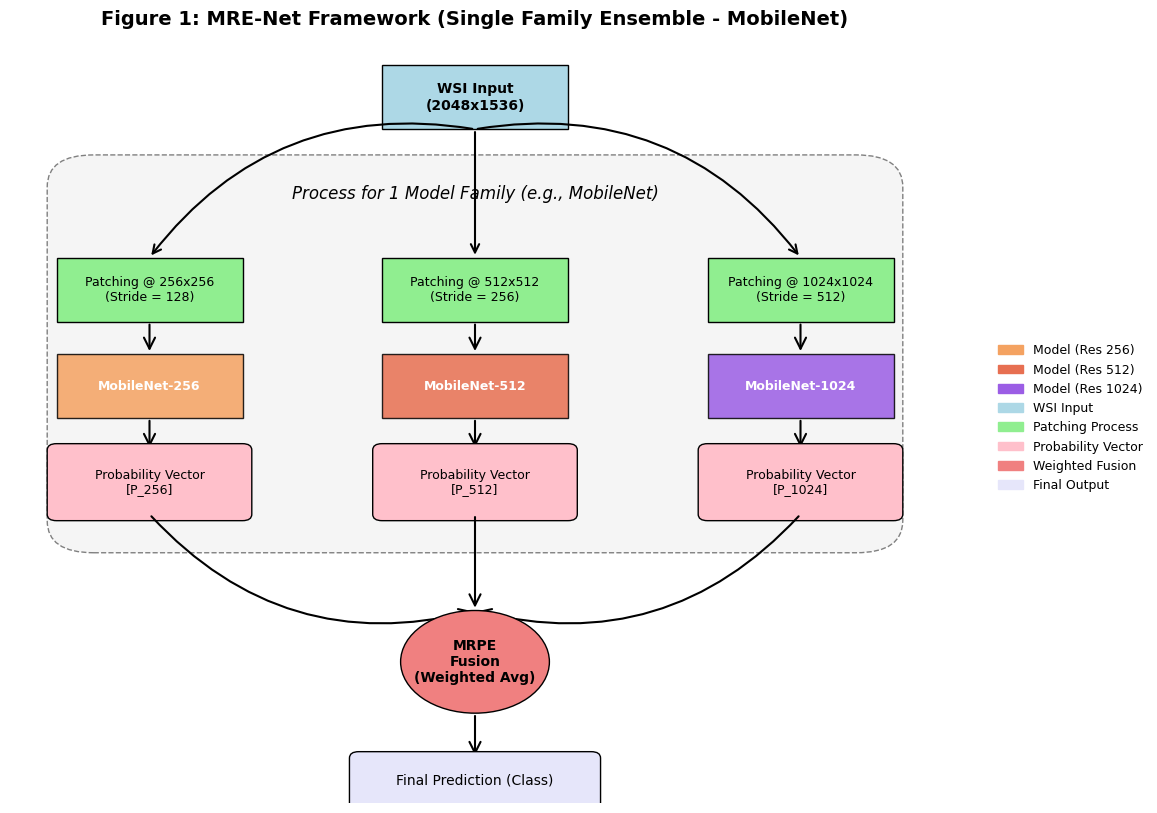

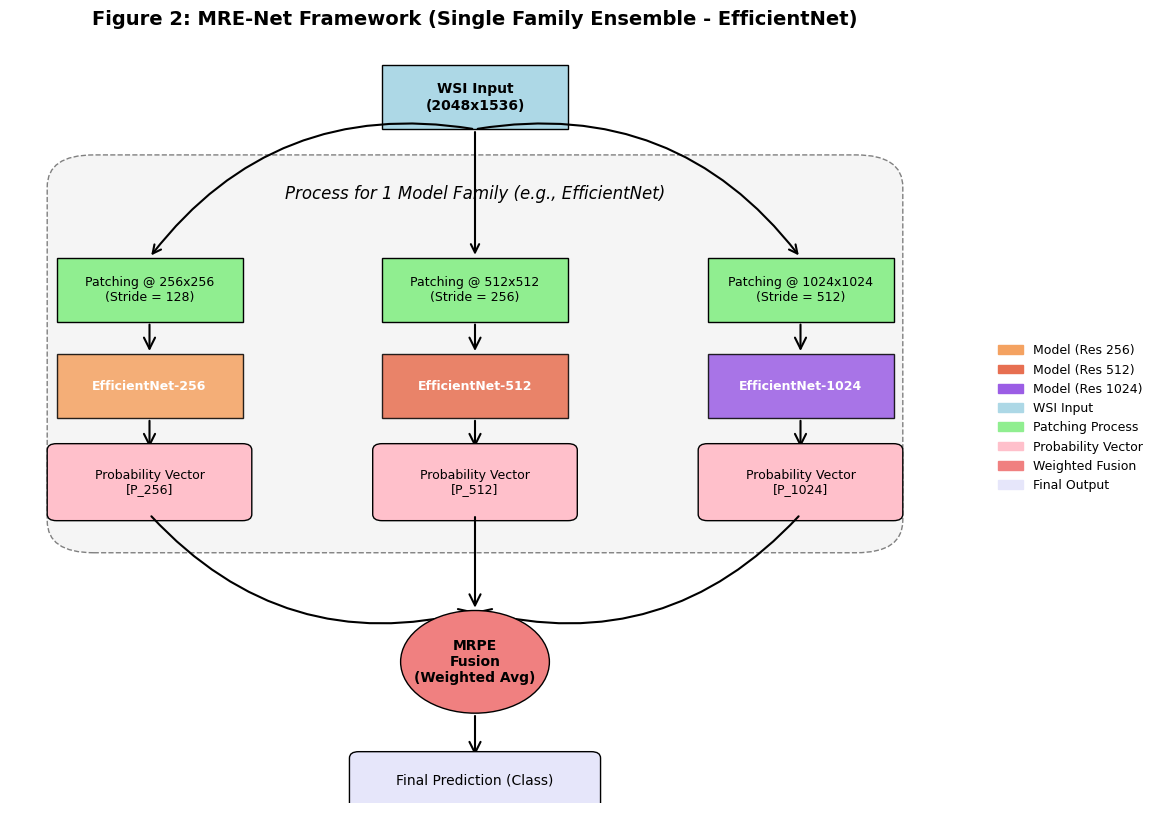

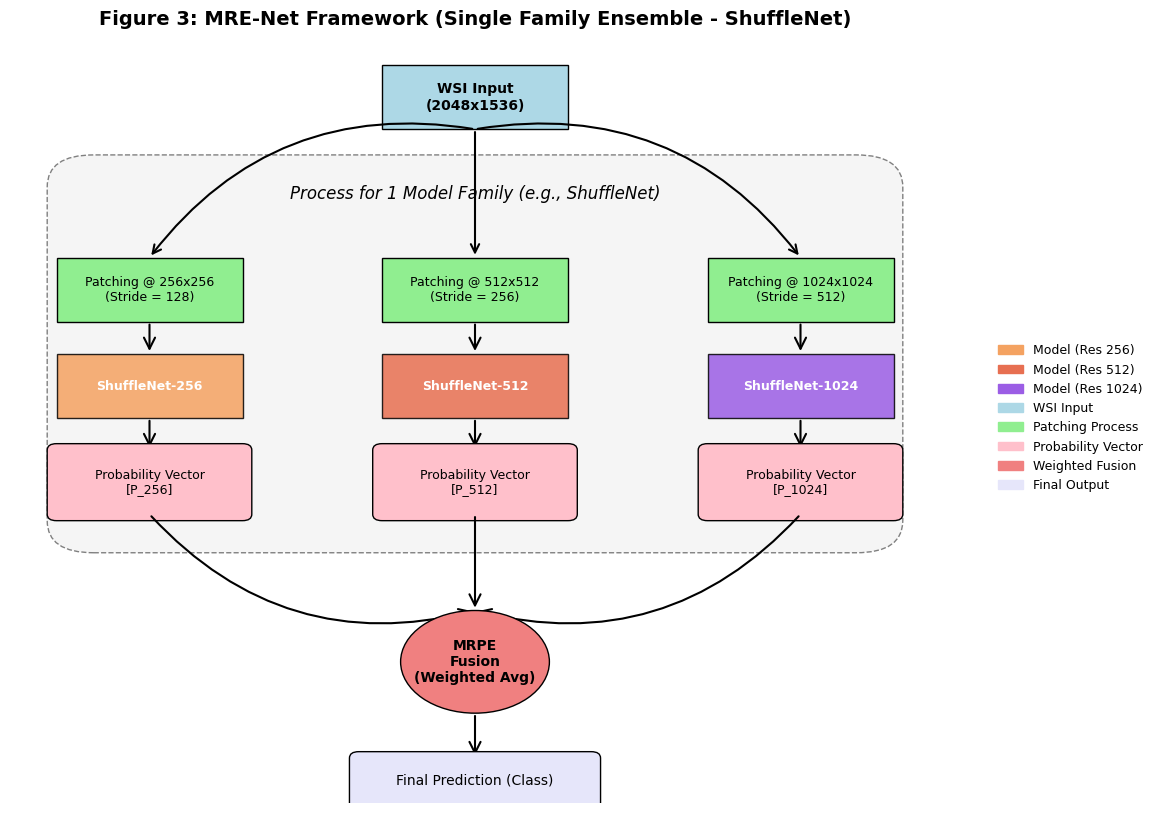

In [ ]:
#cell 26

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import os

# Create logs directory if it doesn't exist
# (This is where the images will be saved)
os.makedirs('logs', exist_ok=True)

# 1. MobileNet Flowchart (Figure 1)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)
ax.axis('off')

# WSI Input
ax.add_patch(patches.Rectangle((4.0, 10.5), 2.0, 1.0,
                              fill=True, facecolor='lightblue', edgecolor='black'))
ax.text(5.0, 11.0, 'WSI Input\n(2048x1536)', ha='center', va='center',
        fontsize=10, weight='bold')

# Title Box for the Family
ax.add_patch(FancyBboxPatch((0.5, 4.0), 9.0, 6.0,
                           boxstyle="round,pad=0.1,rounding_size=0.5", 
                           facecolor='whitesmoke', edgecolor='gray', linestyle='--'))
ax.text(5.0, 9.5, 'Process for 1 Model Family (e.g., MobileNet)', 
        ha='center', va='center', fontsize=12, style='italic')

# Parallel Resolution Branches
res_x_coords = [1.5, 5.0, 8.5]
resolutions_text = [256, 512, 1024]
models_text = ['MobileNet-256', 'MobileNet-512', 'MobileNet-1024']
# Colors assigned per-resolution, matching your provided chart
colors = ['#f4a261', '#e76f51', '#9b5de5'] 
legend_patches = [] 

# Arrow from WSI to the 3 patch boxes
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[0], 8.5),
                                     connectionstyle="arc3,rad=0.3",
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[1], 8.5),
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[2], 8.5),
                                     connectionstyle="arc3,rad=-0.3",
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))

for i, x in enumerate(res_x_coords):
    res = resolutions_text[i]
    model_name = models_text[i]
    
    # Box for Patches
    ax.add_patch(patches.Rectangle((x-1.0, 7.5), 2.0, 1.0,
                                  fill=True, facecolor='lightgreen', edgecolor='black'))
    ax.text(x, 8.0, f'Patching @ {res}x{res}\n(Stride = {res//2})', ha='center', va='center', fontsize=9)
    
    # Arrow from Patch to Model
    ax.add_patch(patches.FancyArrowPatch((x, 7.5), (x, 7.0),
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))
    
    # Box for CNN Model
    face_color = colors[i]
    ax.add_patch(patches.Rectangle((x-1.0, 6.0), 2.0, 1.0,
                                  fill=True, facecolor=face_color, alpha=0.85, edgecolor='black'))
    ax.text(x, 6.5, model_name, ha='center', va='center', fontsize=9, weight='bold', color='white')
    
    legend_patches.append(patches.Patch(color=face_color, label=f'Model (Res {res})'))

    # Arrow from Model to Probability Vector
    ax.add_patch(patches.FancyArrowPatch((x, 6.0), (x, 5.5),
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))
    
    ax.add_patch(FancyBboxPatch((x-1.0, 4.5), 2.0, 1.0,
                               boxstyle="round,pad=0.1", facecolor='pink', edgecolor='black'))
    ax.text(x, 5.0, f'Probability Vector\n[P_{res}]', ha='center', va='center', fontsize=9)

    # Arrow from Probability Vector to Fusion
    ax.add_patch(patches.FancyArrowPatch((x, 4.5), (5.0, 3.0),
                                         connectionstyle=f"arc3,rad={0.3 * (1-i)}",
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))

# Fusion (Weighted Average of Probabilities)
ax.add_patch(patches.Circle((5.0, 2.2), 0.8, facecolor='lightcoral', edgecolor='black'))
ax.text(5.0, 2.2, 'MRPE\nFusion\n(Weighted Avg)', ha='center', va='center', fontsize=10, weight='bold')

# Output
ax.add_patch(patches.FancyArrowPatch((5.0, 1.4), (5.0, 0.7),
                                     arrowstyle='->', mutation_scale=20, linewidth=1.5))
ax.add_patch(FancyBboxPatch((3.75, 0.0), 2.5, 0.7, boxstyle="round,pad=0.1",
                           fill=True, facecolor='lavender', edgecolor='black'))
ax.text(5.0, 0.35, 'Final Prediction (Class)', ha='center', va='center', fontsize=10)

# Legend
legend_patches.append(patches.Patch(color='lightblue', label='WSI Input'))
legend_patches.append(patches.Patch(color='lightgreen', label='Patching Process'))
legend_patches.append(patches.Patch(color='pink', label='Probability Vector'))
legend_patches.append(patches.Patch(color='lightcoral', label='Weighted Fusion'))
legend_patches.append(patches.Patch(color='lavender', label='Final Output'))
ax.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9, frameon=False)

# Final Touches
plt.title('Figure 1: MRE-Net Framework (Single Family Ensemble - MobileNet)', fontsize=14, weight='bold')
plt.savefig(os.path.join('logs', 'mre_framework_mobilenet.png'), dpi=300, bbox_inches='tight')
plt.show()


# 2. EfficientNet Flowchart (Figure 2)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)
ax.axis('off')

# WSI Input
ax.add_patch(patches.Rectangle((4.0, 10.5), 2.0, 1.0,
                              fill=True, facecolor='lightblue', edgecolor='black'))
ax.text(5.0, 11.0, 'WSI Input\n(2048x1536)', ha='center', va='center',
        fontsize=10, weight='bold')

# Title Box for the Family
ax.add_patch(FancyBboxPatch((0.5, 4.0), 9.0, 6.0,
                           boxstyle="round,pad=0.1,rounding_size=0.5", 
                           facecolor='whitesmoke', edgecolor='gray', linestyle='--'))
ax.text(5.0, 9.5, 'Process for 1 Model Family (e.g., EfficientNet)', 
        ha='center', va='center', fontsize=12, style='italic')

# Parallel Resolution Branches
res_x_coords = [1.5, 5.0, 8.5]
resolutions_text = [256, 512, 1024]
models_text = ['EfficientNet-256', 'EfficientNet-512', 'EfficientNet-1024'] # <-- CHANGED
colors = ['#f4a261', '#e76f51', '#9b5de5'] # Using same color-per-res logic
legend_patches = [] 

# Arrow from WSI to the 3 patch boxes
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[0], 8.5),
                                     connectionstyle="arc3,rad=0.3",
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[1], 8.5),
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[2], 8.5),
                                     connectionstyle="arc3,rad=-0.3",
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))

for i, x in enumerate(res_x_coords):
    res = resolutions_text[i]
    model_name = models_text[i]
    
    # Box for Patches
    ax.add_patch(patches.Rectangle((x-1.0, 7.5), 2.0, 1.0,
                                  fill=True, facecolor='lightgreen', edgecolor='black'))
    ax.text(x, 8.0, f'Patching @ {res}x{res}\n(Stride = {res//2})', ha='center', va='center', fontsize=9)
    
    # Arrow from Patch to Model
    ax.add_patch(patches.FancyArrowPatch((x, 7.5), (x, 7.0),
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))
    
    # Box for CNN Model
    face_color = colors[i]
    ax.add_patch(patches.Rectangle((x-1.0, 6.0), 2.0, 1.0,
                                  fill=True, facecolor=face_color, alpha=0.85, edgecolor='black'))
    ax.text(x, 6.5, model_name, ha='center', va='center', fontsize=9, weight='bold', color='white')
    
    legend_patches.append(patches.Patch(color=face_color, label=f'Model (Res {res})'))

    # Arrow from Model to Probability Vector
    ax.add_patch(patches.FancyArrowPatch((x, 6.0), (x, 5.5),
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))
    
    ax.add_patch(FancyBboxPatch((x-1.0, 4.5), 2.0, 1.0,
                               boxstyle="round,pad=0.1", facecolor='pink', edgecolor='black'))
    ax.text(x, 5.0, f'Probability Vector\n[P_{res}]', ha='center', va='center', fontsize=9)

    # Arrow from Probability Vector to Fusion
    ax.add_patch(patches.FancyArrowPatch((x, 4.5), (5.0, 3.0),
                                         connectionstyle=f"arc3,rad={0.3 * (1-i)}",
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))

# Fusion (Weighted Average of Probabilities)
ax.add_patch(patches.Circle((5.0, 2.2), 0.8, facecolor='lightcoral', edgecolor='black'))
ax.text(5.0, 2.2, 'MRPE\nFusion\n(Weighted Avg)', ha='center', va='center', fontsize=10, weight='bold')

# Output
ax.add_patch(patches.FancyArrowPatch((5.0, 1.4), (5.0, 0.7),
                                     arrowstyle='->', mutation_scale=20, linewidth=1.5))
ax.add_patch(FancyBboxPatch((3.75, 0.0), 2.5, 0.7, boxstyle="round,pad=0.1",
                           fill=True, facecolor='lavender', edgecolor='black'))
ax.text(5.0, 0.35, 'Final Prediction (Class)', ha='center', va='center', fontsize=10)

# Legend
legend_patches.append(patches.Patch(color='lightblue', label='WSI Input'))
legend_patches.append(patches.Patch(color='lightgreen', label='Patching Process'))
legend_patches.append(patches.Patch(color='pink', label='Probability Vector'))
legend_patches.append(patches.Patch(color='lightcoral', label='Weighted Fusion'))
legend_patches.append(patches.Patch(color='lavender', label='Final Output'))
ax.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9, frameon=False)

# Final Touches
plt.title('Figure 2: MRE-Net Framework (Single Family Ensemble - EfficientNet)', fontsize=14, weight='bold')
plt.savefig(os.path.join('logs', 'mre_framework_efficientnet.png'), dpi=300, bbox_inches='tight')
plt.show()


# 3. ShuffleNet Flowchart (Figure 3)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)
ax.axis('off')

# WSI Input
ax.add_patch(patches.Rectangle((4.0, 10.5), 2.0, 1.0,
                              fill=True, facecolor='lightblue', edgecolor='black'))
ax.text(5.0, 11.0, 'WSI Input\n(2048x1536)', ha='center', va='center',
        fontsize=10, weight='bold')

# Title Box for the Family
ax.add_patch(FancyBboxPatch((0.5, 4.0), 9.0, 6.0,
                           boxstyle="round,pad=0.1,rounding_size=0.5", 
                           facecolor='whitesmoke', edgecolor='gray', linestyle='--'))
ax.text(5.0, 9.5, 'Process for 1 Model Family (e.g., ShuffleNet)', 
        ha='center', va='center', fontsize=12, style='italic')

# Parallel Resolution Branches
res_x_coords = [1.5, 5.0, 8.5]
resolutions_text = [256, 512, 1024]
models_text = ['ShuffleNet-256', 'ShuffleNet-512', 'ShuffleNet-1024'] # <-- CHANGED
colors = ['#f4a261', '#e76f51', '#9b5de5'] # Using same color-per-res logic
legend_patches = [] 

# Arrow from WSI to the 3 patch boxes
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[0], 8.5),
                                     connectionstyle="arc3,rad=0.3",
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[1], 8.5),
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[2], 8.5),
                                     connectionstyle="arc3,rad=-0.3",
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))

for i, x in enumerate(res_x_coords):
    res = resolutions_text[i]
    model_name = models_text[i]
    
    # Box for Patches
    ax.add_patch(patches.Rectangle((x-1.0, 7.5), 2.0, 1.0,
                                  fill=True, facecolor='lightgreen', edgecolor='black'))
    ax.text(x, 8.0, f'Patching @ {res}x{res}\n(Stride = {res//2})', ha='center', va='center', fontsize=9)
    
    # Arrow from Patch to Model
    ax.add_patch(patches.FancyArrowPatch((x, 7.5), (x, 7.0),
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))
    
    # Box for CNN Model
    face_color = colors[i]
    ax.add_patch(patches.Rectangle((x-1.0, 6.0), 2.0, 1.0,
                                  fill=True, facecolor=face_color, alpha=0.85, edgecolor='black'))
    ax.text(x, 6.5, model_name, ha='center', va='center', fontsize=9, weight='bold', color='white')
    
    legend_patches.append(patches.Patch(color=face_color, label=f'Model (Res {res})'))

    # Arrow from Model to Probability Vector
    ax.add_patch(patches.FancyArrowPatch((x, 6.0), (x, 5.5),
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))
    
    ax.add_patch(FancyBboxPatch((x-1.0, 4.5), 2.0, 1.0,
                               boxstyle="round,pad=0.1", facecolor='pink', edgecolor='black'))
    ax.text(x, 5.0, f'Probability Vector\n[P_{res}]', ha='center', va='center', fontsize=9)

    # Arrow from Probability Vector to Fusion
    ax.add_patch(patches.FancyArrowPatch((x, 4.5), (5.0, 3.0),
                                         connectionstyle=f"arc3,rad={0.3 * (1-i)}",
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))

# Fusion (Weighted Average of Probabilities)
ax.add_patch(patches.Circle((5.0, 2.2), 0.8, facecolor='lightcoral', edgecolor='black'))
ax.text(5.0, 2.2, 'MRPE\nFusion\n(Weighted Avg)', ha='center', va='center', fontsize=10, weight='bold')

# Output
ax.add_patch(patches.FancyArrowPatch((5.0, 1.4), (5.0, 0.7),
                                     arrowstyle='->', mutation_scale=20, linewidth=1.5))
ax.add_patch(FancyBboxPatch((3.75, 0.0), 2.5, 0.7, boxstyle="round,pad=0.1",
                           fill=True, facecolor='lavender', edgecolor='black'))
ax.text(5.0, 0.35, 'Final Prediction (Class)', ha='center', va='center', fontsize=10)

# Legend
legend_patches.append(patches.Patch(color='lightblue', label='WSI Input'))
legend_patches.append(patches.Patch(color='lightgreen', label='Patching Process'))
legend_patches.append(patches.Patch(color='pink', label='Probability Vector'))
legend_patches.append(patches.Patch(color='lightcoral', label='Weighted Fusion'))
legend_patches.append(patches.Patch(color='lavender', label='Final Output'))
ax.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9, frameon=False)

# Final Touches
plt.title('Figure 3: MRE-Net Framework (Single Family Ensemble - ShuffleNet)', fontsize=14, weight='bold')
plt.savefig(os.path.join('logs', 'mre_framework_shufflenet.png'), dpi=300, bbox_inches='tight')
plt.show()

In [11]:
#cell 27

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import os

# Ensure the 'logs' directory exists
os.makedirs('logs', exist_ok=True)

# Setup Figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)
ax.axis('off')

# 1. WSI Input
ax.add_patch(patches.Rectangle((4.0, 10.5), 2.0, 1.0,
                              fill=True, facecolor='lightblue', edgecolor='black'))
ax.text(5.0, 11.0, 'WSI Input\n(2048x1536)', ha='center', va='center',
        fontsize=10, weight='bold')

# Title Box for the Family
ax.add_patch(FancyBboxPatch((0.5, 4.0), 9.0, 6.0,
                           boxstyle="round,pad=0.1,rounding_size=0.5", 
                           facecolor='whitesmoke', edgecolor='gray', linestyle='--'))
ax.text(5.0, 9.5, 'Process for 1 Model Family (e.g., MobileNet, EfficientNet, or ShuffleNet)', 
        ha='center', va='center', fontsize=12, style='italic')

# 2. Parallel Resolution Branches
res_x_coords = [1.5, 5.0, 8.5]
resolutions_text = [256, 512, 1024]
# Using a generic name as this code is used for all 3 families
models_text = ['CNN Model (Res 256)', 'CNN Model (Res 512)', 'CNN Model (Res 1024)']
colors = ['#f4a261', '#e76f51', '#9b5de5'] 
legend_patches = [] 

# Arrow from WSI to the 3 patch boxes
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[0], 8.5),
                                     connectionstyle="arc3,rad=0.3",
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[1], 8.5),
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))
ax.add_patch(patches.FancyArrowPatch((5.0, 10.5), (res_x_coords[2], 8.5),
                                     connectionstyle="arc3,rad=-0.3",
                                     arrowstyle='->', mutation_scale=15, linewidth=1.5))

for i, x in enumerate(res_x_coords):
    res = resolutions_text[i]
    model_name = models_text[i]
    
    # Box for Patches
    ax.add_patch(patches.Rectangle((x-1.0, 7.5), 2.0, 1.0,
                                  fill=True, facecolor='lightgreen', edgecolor='black'))
    ax.text(x, 8.0, f'Patching @ {res}x{res}\n(Stride = {res//2})', ha='center', va='center', fontsize=9)
    
    # Arrow from Patch to Model
    ax.add_patch(patches.FancyArrowPatch((x, 7.5), (x, 7.0),
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))
    
    # Box for CNN Model
    face_color = colors[i]
    ax.add_patch(patches.Rectangle((x-1.0, 6.0), 2.0, 1.0,
                                  fill=True, facecolor=face_color, alpha=0.85, edgecolor='black'))
    ax.text(x, 6.5, model_name, ha='center', va='center', fontsize=9, weight='bold', color='white')
    
    legend_patches.append(patches.Patch(color=face_color, label=f'Model (Res {res})'))

    # Arrow from Model to Probability Vector
    ax.add_patch(patches.FancyArrowPatch((x, 6.0), (x, 5.5),
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))
    
    ax.add_patch(FancyBboxPatch((x-1.0, 4.5), 2.0, 1.0,
                               boxstyle="round,pad=0.1", facecolor='pink', edgecolor='black'))
    ax.text(x, 5.0, f'Probability Vector\n[P_{res}]', ha='center', va='center', fontsize=9)

    # Arrow from Probability Vector to Fusion
    ax.add_patch(patches.FancyArrowPatch((x, 4.5), (5.0, 3.0),
                                         connectionstyle=f"arc3,rad={0.3 * (1-i)}",
                                         arrowstyle='->', mutation_scale=20, linewidth=1.5))

# 3. Fusion (Weighted Average of Probabilities)
ax.add_patch(patches.Circle((5.0, 2.2), 0.8, facecolor='lightcoral', edgecolor='black'))
ax.text(5.0, 2.2, 'MRPE\nFusion\n(Weighted Avg)', ha='center', va='center', fontsize=10, weight='bold')

# 4. Output
ax.add_patch(patches.FancyArrowPatch((5.0, 1.4), (5.0, 0.7),
                                     arrowstyle='->', mutation_scale=20, linewidth=1.5))
ax.add_patch(FancyBboxPatch((3.75, 0.0), 2.5, 0.7, boxstyle="round,pad=0.1",
                           fill=True, facecolor='lavender', edgecolor='black'))
ax.text(5.0, 0.35, 'Final Prediction (Class)', ha='center', va='center', fontsize=10)

# 5. Legend
legend_patches.append(patches.Patch(color='lightblue', label='WSI Input'))
legend_patches.append(patches.Patch(color='lightgreen', label='Patching Process'))
legend_patches.append(patches.Patch(color='pink', label='Probability Vector'))
legend_patches.append(patches.Patch(color='lightcoral', label='Weighted Fusion'))
legend_patches.append(patches.Patch(color='lavender', label='Final Output'))
ax.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9, frameon=False)

# 6. Final Touches
plt.title('MRE-Net Framework (Single Family Ensemble)', fontsize=14, weight='bold')
output_path = os.path.join('logs', 'mre_framework.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Flowchart saved to: {output_path}")
plt.show()

Flowchart saved to: logs/mre_framework.png


<Figure size 1200x1000 with 1 Axes>

In [ ]:
# CELL 28 : Gradio Application

import os
import time
import warnings
import traceback
import logging
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision 
from torchvision import datasets, models, transforms
import timm 
from PIL import Image, ImageFilter
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, jaccard_score
)
from sklearn.model_selection import train_test_split
from torch.amp import autocast
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from statsmodels.stats.inter_rater import fleiss_kappa
import cv2
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import pearsonr
import gradio as gr
import tempfile
import copy

# Add model classes for safe loading
import torch.serialization
from torchvision.models.mobilenetv3 import MobileNetV3
from torchvision.models.shufflenetv2 import ShuffleNetV2
from timm.models.efficientnet import EfficientNet

print("--- Initializing Gradio App (18-Model Version) ---")

# 1. GLOBAL SETUP & CONFIGURATION
# Device Setup
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"--- Using device: {device} ---")

# Model & Data Config
resolutions = [256, 512, 1024]
model_families = ['mobilenet_v3_small', 'efficientnet_b0', 'shufflenet_v2_x1_0']
class_names = ['Benign', 'InSitu', 'Invasive', 'Normal']
num_classes = len(class_names)
input_size = 224


# File Paths
base_dir = os.getcwd()
models_fp32_dir = os.path.join(base_dir, "models", "fp32")
models_fp16_dir = os.path.join(base_dir, "models", "fp16")
processed_dir = os.path.join(base_dir, "data", "processed")
logs_dir = os.path.join(base_dir, "logs")
raw_test_dir = 'data/raw/bach/ICIAR2018_BACH_Challenge/Photos'
gt_csv_path = 'ground_truth_regions.csv'
patho_csv_path = 'pathologist_scores.csv'
heatmap_output_dir = os.path.join(logs_dir, "evaluation_heatmaps_gradio")

os.makedirs(logs_dir, exist_ok=True)
os.makedirs(heatmap_output_dir, exist_ok=True)
if not os.path.exists(models_fp32_dir): print(f"WARNING: FP32 models directory not found: {models_fp32_dir}")
if not os.path.exists(models_fp16_dir): print(f"WARNING: FP16 models directory not found: {models_fp16_dir}")
if not os.path.exists(processed_dir): print(f"WARNING: Processed data directory not found: {processed_dir}")


# Transforms
model_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. HELPER FUNCTIONS
def load_model_structure(model_family: str, num_classes: int = 4):
    """Loads the model *structure* (no weights) - CORRECTLY MATCHES TRAINING CELL 4"""
    model = None
    if model_family == 'mobilenet_v3_small':
        model = models.mobilenet_v3_small(weights=None)
        in_features_final_layer = model.classifier[3].in_features # 1024
        original_first_linear = model.classifier[0] # This is Linear(in=576, out=1024)
        
        # Recreate the exact nn.Sequential from training
        model.classifier = nn.Sequential(
            original_first_linear,               # [0] Linear(576, 1024)
            nn.Hardswish(),                      # [1]
            # Set to 0.5 and inplace=False
            nn.Dropout(p=0.5, inplace=False),    
            nn.Linear(in_features_final_layer, num_classes) # [3] Linear(1024, 4)
        )
    elif model_family == 'efficientnet_b0':
        model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=num_classes) 
        in_features = model.get_classifier().in_features
        # This structure MUST match Cell 4
        model.classifier = nn.Sequential(
            # Set to 0.5 and inplace=False
            nn.Dropout(p=0.5, inplace=False), 
            nn.Linear(in_features, num_classes) # [1]
        )
    elif model_family == 'shufflenet_v2_x1_0':
        model = models.shufflenet_v2_x1_0(weights=None) 
        in_features = model.fc.in_features
        # This structure MUST match Cell 4
        model.fc = nn.Sequential(
            # Set to 0.5 (inplace was already False by default)
            nn.Dropout(p=0.5),  
            nn.Linear(in_features, num_classes) # [1]
        )
    else:
        raise ValueError(f"Unknown model family: {model_family}")
    return model

def get_target_layers(model, model_family):
    """Gets the correct target layer for Grad-CAM based on model family"""
    try:
        if model_family == 'mobilenet_v3_small':
            return [model.features[-1]]
        elif model_family == 'efficientnet_b0':
            # timm EfficientNet has a different structure
            return [model.conv_head]
        elif model_family == 'shufflenet_v2_x1_0':
            return [model.conv5]
    except Exception as e:
        print(f"Error getting target layer for {model_family}: {e}")
        # A generic fallback
        for layer in reversed(list(model.modules())):
            if isinstance(layer, torch.nn.Conv2d):
                return [layer]
        return None


def load_all_models():
    """Loads all 18 models into two global dictionaries."""
    
    torch.serialization.add_safe_globals([
        torchvision.models.mobilenetv3.MobileNetV3,
        timm.models.efficientnet.EfficientNet,
        torchvision.models.shufflenetv2.ShuffleNetV2
    ])
    
    g_models_fp32 = {}
    g_models_fp16 = {}
    
    for family in model_families:
        for res in resolutions:
            run_id = f"{family}_patch{res}"
            
            # Load FP32
            fp32_path = os.path.join(models_fp32_dir, f'model_{run_id}.pth')
            if os.path.exists(fp32_path):
                try:
                    model_fp32 = load_model_structure(family, num_classes)
                    checkpoint = torch.load(fp32_path, map_location=device)
                    model_fp32.load_state_dict(checkpoint.get('model_state_dict', checkpoint))
                    model_fp32.to(device).eval()
                    g_models_fp32[run_id] = model_fp32
                except Exception as e:
                    print(f"Error loading FP32 model {run_id}: {e}")
                    traceback.print_exc() 
            else:
                print(f"Warning: FP32 model not found: {fp32_path}")

            # Load FP16
            fp16_path = os.path.join(models_fp16_dir, f'model_{run_id}_fp16.pth')
            if os.path.exists(fp16_path):
                try:
                    model_fp16 = torch.load(fp16_path, map_location=device, weights_only=False)
                    model_fp16.to(device).eval()
                    g_models_fp16[run_id] = model_fp16
                except Exception as e:
                    print(f"Error loading FP16 model {run_id}: {e}")
                    traceback.print_exc() 
            else:
                print(f"Warning: FP16 model not found: {fp16_path}")
                
    print(f"--- Loaded {len(g_models_fp32)} FP32 and {len(g_models_fp16)} FP16 models ---")
    return g_models_fp32, g_models_fp16


def get_dataloaders(res: int, batch_size: int = 32, mode='eval'):
    data_path = os.path.join(processed_dir, f'patches_{res}')
    val_path = os.path.join(data_path, 'val')
    if not os.path.exists(val_path): print(f"Warning: Val path not found: {val_path}"); return None, None, None
    try:
        val_ds = datasets.ImageFolder(val_path, model_transform)
        if len(val_ds) == 0: print(f"Warning: Val dataset empty: {val_path}"); return None, None, None
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=min(4, os.cpu_count()), pin_memory=True)
        return None, val_loader, None
    except Exception as e: print(f"Error loading 'val' dataset at {data_path}: {e}"); return None, None, None


# compute_weights
# This function is updated to returns the metrics it calculates
def compute_weights(model_family, fp16=False, weighting_scheme='mrpe'):
    """Computes weights and ALSO returns the calculated val metrics."""
    global g_models_fp32, g_models_fp16
    
    scheme_name = weighting_scheme.upper()
    print(f"\n--- Computing {model_family} {'FP16' if fp16 else 'FP32'} Weights ({scheme_name}) ---")
    if weighting_scheme == 'equal': 
        return {res: 1.0 / len(resolutions) for res in resolutions}, {}, {}
    
    weights, accuracies, times_per_img = {}, {}, {}
    val_loaders = {}
    missing_loader = False
    
    for res in resolutions:
        _, val_loader, _ = get_dataloaders(res, mode='val')
        if val_loader is None: print(f"Error: Val loader missing for res {res}."); missing_loader=True; break
        val_loaders[res] = val_loader
        
    if missing_loader: 
        print("Fallback: Using equal weights.")
        return {r: 1.0 / len(resolutions) for r in resolutions}, {}, {}
    
    for res in resolutions:
        run_id = f"{model_family}_patch{res}"
        model_cache = g_models_fp16 if fp16 else g_models_fp32
        
        if run_id not in model_cache:
            print(f"  Error: Model {run_id} not in cache. Skipping weight calc for res {res}.")
            accuracies[res]=0.0; times_per_img[res]=float('inf')
            continue
            
        model = model_cache[run_id]
        model.eval()
        start_time = time.time(); preds, labels = [], []
        
        with torch.no_grad():
            for inputs, lbls in val_loaders[res]:
                inputs = inputs.to(device)
                if fp16 and device.type != 'cpu': inputs = inputs.half()
                
                with autocast(device_type=device.type, enabled=(fp16 and device.type != 'cpu')):
                    outputs = model(inputs)
                    
                preds.extend(torch.argmax(outputs, 1).cpu().numpy()); labels.extend(lbls.numpy())
                
        dataset_len = len(val_loaders[res].dataset)
        elapsed_time = time.time() - start_time
        time_per_img = elapsed_time / dataset_len if dataset_len > 0 else float('inf')
        acc = accuracy_score(labels, preds)
        accuracies[res] = acc; times_per_img[res] = time_per_img if time_per_img > 1e-9 else float('inf')
        print(f"  Res {res}: Acc={acc:.4f}, Time/Img={times_per_img[res]*1000:.2f} ms")
        
    raw_weights = {res: accuracies.get(res,0) / times_per_img.get(res,float('inf')) if weighting_scheme=='mrpe' else accuracies.get(res,0) for res in resolutions}
    total_weight = sum(w for w in raw_weights.values() if np.isfinite(w))
    
    if total_weight > 1e-9: weights = {res: (raw_weights[res] / total_weight) if np.isfinite(raw_weights.get(res,0)) else 0.0 for res in resolutions}
    else: print(f"Warn: Total weight {total_weight}. Using equal weights."); weights = {res: 1.0 / len(resolutions) for res in resolutions}
    
    print(f"Computed Weights ({model_family} {scheme_name}): {weights}")
    
    #Return calculated metrics
    return weights, accuracies, times_per_img


def extract_patches_temp(img: Image.Image, patch_size: int, stride: int):
    patches = []; img_width, img_height = img.size
    if img_width < patch_size or img_height < patch_size:
        new_size=(max(img_width, patch_size), max(img_height, patch_size))
        try: img=img.resize(new_size, Image.Resampling.LANCZOS); img_width, img_height=new_size
        except: print("Warn: Img resize failed."); return []
    for y in range(0, img_height-patch_size+1, stride):
        for x in range(0, img_width-patch_size+1, stride):
            try: patch=img.crop((x, y, x+patch_size, y+patch_size)); patches.append(patch)
            except: print("Warn: Patch crop failed."); continue
    if not patches:
        try: patch=img.resize((patch_size, patch_size), Image.Resampling.LANCZOS); patches.append(patch)
        except: print("Warn: Fallback resize failed."); return []
    return patches


def generate_heatmap(model, model_family, input_tensor_fp32, target_class):
    """
    Generates a Grad-CAM heatmap, robustly handling FP16/FP32 models
    by creating a guaranteed FP32 copy for CAM.
    """
    # model = model.to(device); # No longer needed, model is just for state_dict
    model.eval() # Ensure model is in eval mode
    
    try: 
        # 1. Create a new FP32 model structure
        model_fp32_for_cam = load_model_structure(model_family, num_classes)
        
        # 2. Load the state dict from the (potentially FP16) model
        # This upcasts the weights to FP32
        model_fp32_for_cam.load_state_dict(model.state_dict())
        model_fp32_for_cam.to(device).eval()
        
        # 3. Get target layers from the new FP32 model
        target_layers = get_target_layers(model_fp32_for_cam, model_family)
        if not target_layers: 
            print(f"ERROR: No target layers found for {model_family}"); 
            return None
    except Exception as e: 
        print(f"ERROR getting target layers or loading state_dict: {e}"); 
        return None

    # 4. Use a simple wrapper (no .float() needed inside, as model is already FP32)
    class ModelWrapper(torch.nn.Module):
        def __init__(self, model): 
            super().__init__()
            self.model = model
        def forward(self, x): 
            return self.model(x) # Input tensor is already guaranteed FP32
    
    model_for_cam = ModelWrapper(model_fp32_for_cam)
    # No need for .float() or .to(device) again, already done
    
    cam = GradCAM(model=model_for_cam, target_layers=target_layers)
    targets = [ClassifierOutputTarget(target_class)]
    
    try:
        # 5. Ensure input tensor is float() one last time
        grayscale_cam = cam(input_tensor=input_tensor_fp32.float().to(device), targets=targets)
        
        if grayscale_cam is None or len(grayscale_cam) == 0: 
            print("ERROR: GradCAM returned empty."); 
            return None
        
        cam_result = grayscale_cam[0, :]
        hm_normalized = cv2.normalize(cam_result, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return hm_normalized
    except Exception as e: 
        print(f"ERROR during GradCAM execution: {e}"); 
        traceback.print_exc(); 
        return None


def compute_iou(heatmap, gt_box_dict, threshold=0.5):
    if heatmap is None: return np.nan
    try:
        heatmap_bin = (heatmap > threshold).astype(np.uint8); h, w = heatmap.shape
        x_min=max(0,int(gt_box_dict['x_min']*w)); y_min=max(0,int(gt_box_dict['y_min']*h))
        x_max=min(w,int(gt_box_dict['x_max']*w)); y_max=min(h,int(gt_box_dict['y_max']*h))
        if y_min >= y_max or x_min >= x_max: return 0.0
        gt_mask = np.zeros_like(heatmap_bin); gt_mask[y_min:y_max, x_min:x_max] = 1
        intersection = np.logical_and(gt_mask, heatmap_bin).sum(); union = np.logical_or(gt_mask, heatmap_bin).sum()
        return intersection / union if union > 0 else 0.0
    except Exception as e: print(f"Error in compute_iou: {e}"); return np.nan


def compute_fleiss_kappa(df_ratings):
    try:
        n_categories = num_classes; n_subjects = len(df_ratings)
        count_matrix = np.zeros((n_subjects, n_categories), dtype=int)
        pathologist_cols = df_ratings.filter(regex='^p[0-9]+').columns
        if pathologist_cols.empty: return np.nan
        for i, (idx, row) in enumerate(df_ratings.iterrows()):
            ratings = pd.to_numeric(row[pathologist_cols].values, errors='coerce')
            for rating in ratings:
                if pd.notna(rating) and 0 <= rating < n_categories: count_matrix[i, int(rating)] += 1
        if np.any(count_matrix.sum(axis=1) == 0):
             valid_rows = count_matrix.sum(axis=1) > 0
             if not np.any(valid_rows): return np.nan
             count_matrix = count_matrix[valid_rows]
        if count_matrix.shape[0] < 2: return np.nan
        return fleiss_kappa(count_matrix, method='fleiss')
    except Exception as e: print(f"Error computing Fleiss' Kappa: {e}"); return np.nan


def add_gaussian_blur(image, sigma=2.0):
    return image.filter(ImageFilter.GaussianBlur(radius=sigma))


def ensemble_inference(image_path, model_family, weights, fp16=False):
    global g_models_fp32, g_models_fp16
    img = Image.open(image_path).convert("RGB"); probs = []; device_to_use = device
    
    for res in resolutions:
        if weights.get(res, 0) == 0: 
            probs.append(None); continue
            
        try:
            run_id = f"{model_family}_patch{res}"
            model_cache = g_models_fp16 if fp16 else g_models_fp32
            
            if run_id not in model_cache:
                raise FileNotFoundError(f"Model {run_id} not found in global cache.")
                
            model = model_cache[run_id]
            model.eval()
            
            stride = res // 2; patches = extract_patches_temp(img, res, stride)
            if not patches: 
                probs.append(np.ones((1, num_classes))/num_classes); continue
                
            res_probs = []
            with torch.no_grad():
                for patch in patches:
                    input_tensor = model_transform(patch).unsqueeze(0).to(device_to_use)
                    if fp16 and device.type != 'cpu': input_tensor = input_tensor.half()
                    
                    with autocast(device_type=device.type, enabled=(fp16 and device.type != 'cpu')): 
                        output = model(input_tensor)
                        
                    res_probs.append(torch.softmax(output, 1).cpu().numpy())
                    
            if not res_probs: probs.append(np.ones((1, num_classes))/num_classes)
            else: avg_prob = np.mean(res_probs, axis=0); probs.append(avg_prob)
            
        except Exception as model_e: 
            print(f"ERROR inference {model_family} res {res}: {model_e}"); traceback.print_exc(); probs.append(None)
            
    valid_probs = [p for p in probs if p is not None and isinstance(p, np.ndarray) and p.shape == (1, num_classes)]
    if not valid_probs: return "Error", np.ones(num_classes)/num_classes
    
    fused_prob = np.zeros((1, num_classes)); valid_weights_sum = 0
    if weights is None: weights = {r: 1.0/len(resolutions) for r in resolutions}
    
    for i, res in enumerate(resolutions):
         if i < len(probs) and probs[i] is not None and isinstance(probs[i], np.ndarray) and probs[i].shape == (1, num_classes):
             current_weight = weights.get(res, 0);
             if current_weight > 0: fused_prob += probs[i] * current_weight; valid_weights_sum += current_weight
             
    if valid_weights_sum > 1e-6: fused_prob /= valid_weights_sum
    elif valid_probs: fused_prob = np.mean(valid_probs, axis=0) 
    else: fused_prob = np.ones((1, num_classes)) / num_classes
    
    pred_class_idx = np.argmax(fused_prob); pred_class = class_names[pred_class_idx]
    return pred_class, fused_prob.flatten()
# End Helper Functions


# 3. PRE-COMPUTE METRICS & CM
print("--- Loading all 18 models into memory ---")
g_models_fp32, g_models_fp16 = load_all_models()

#Load Metrics & CMs
print("--- Pre-loading all Metrics and Confusion Matrices ---")

g_eval_metrics = {'fp32': {}, 'fp16': {}, 'agreement_fp16': {}, 'kappa': np.nan}
g_cm_images = {}
placeholder_img_global = Image.new('RGB', (224, 224), color = 'grey')

try:
    # Load FP32 Test Metrics
    fp32_metrics_data = {
        'mobilenet_v3_small_patch256': {'Accuracy': 0.8118, 'F1-Macro': 0.8118, 'Precision-Macro': 0.8127, 'Recall-Macro': 0.8118},
        'mobilenet_v3_small_patch512': {'Accuracy': 0.8424, 'F1-Macro': 0.8422, 'Precision-Macro': 0.8437, 'Recall-Macro': 0.8424},
        'mobilenet_v3_small_patch1024': {'Accuracy': 0.8861, 'F1-Macro': 0.8867, 'Precision-Macro': 0.8885, 'Recall-Macro': 0.8861},
        'efficientnet_b0_patch256': {'Accuracy': 0.8546, 'F1-Macro': 0.8540, 'Precision-Macro': 0.8563, 'Recall-Macro': 0.8546},
        'efficientnet_b0_patch512': {'Accuracy': 0.8695, 'F1-Macro': 0.8690, 'Precision-Macro': 0.8702, 'Recall-Macro': 0.8695},
        'efficientnet_b0_patch1024': {'Accuracy': 0.8639, 'F1-Macro': 0.8648, 'Precision-Macro': 0.8669, 'Recall-Macro': 0.8639},
        'shufflenet_v2_x1_0_patch256': {'Accuracy': 0.7968, 'F1-Macro': 0.7965, 'Precision-Macro': 0.7971, 'Recall-Macro': 0.7968},
        'shufflenet_v2_x1_0_patch512': {'Accuracy': 0.8410, 'F1-Macro': 0.8406, 'Precision-Macro': 0.8420, 'Recall-Macro': 0.8410},
        'shufflenet_v2_x1_0_patch1024': {'Accuracy': 0.7806, 'F1-Macro': 0.7823, 'Precision-Macro': 0.8008, 'Recall-Macro': 0.7806},
    }
    g_eval_metrics['fp32'] = fp32_metrics_data

    # Load FP16 Test Metrics
    fp16_metrics_data = {
        'mobilenet_v3_small_patch256': {'Accuracy': 0.9000, 'F1-Macro': 0.8994, 'Lat': 79.65},
        'mobilenet_v3_small_patch512': {'Accuracy': 0.9167, 'F1-Macro': 0.9160, 'Lat': 80.65},
        'mobilenet_v3_small_patch1024': {'Accuracy': 0.9000, 'F1-Macro': 0.8994, 'Lat': 83.27},
        'efficientnet_b0_patch256': {'Accuracy': 0.9500, 'F1-Macro': 0.9499, 'Lat': 65.91},
        'efficientnet_b0_patch512': {'Accuracy': 0.9000, 'F1-Macro': 0.8999, 'Lat': 65.59},
        'efficientnet_b0_patch1024': {'Accuracy': 0.9167, 'F1-Macro': 0.9160, 'Lat': 66.96},
        'shufflenet_v2_x1_0_patch256': {'Accuracy': 0.8833, 'F1-Macro': 0.8841, 'Lat': 10.88},
        'shufflenet_v2_x1_0_patch512': {'Accuracy': 0.9167, 'F1-Macro': 0.9161, 'Lat': 11.08},
        'shufflenet_v2_x1_0_patch1024': {'Accuracy': 0.7500, 'F1-Macro': 0.7514, 'Lat': 12.40},
    }
    g_eval_metrics['fp16'] = fp16_metrics_data
    
    #Load Agreement Metrics
    g_eval_metrics['agreement_fp16'] = {
        'mobilenet_v3_small': 0.8500,
        'efficientnet_b0': 0.8500,
        'shufflenet_v2_x1_0': 0.8167,
    }
    
    # Load Fleiss Kappa
    if os.path.exists(patho_csv_path):
        patho_df_kappa = pd.read_csv(patho_csv_path)
        g_eval_metrics['kappa'] = compute_fleiss_kappa(patho_df_kappa.filter(regex='^p[0-9]+'))
    else:
        print(f"Warning: {patho_csv_path} not found for Kappa.")

    # Load all 18 Confusion Matrices
    print("Loading Confusion Matrices...")
    for family in model_families:
        for res in resolutions:
            for precision in ['fp32', 'fp16']:
                key = f'{family}_patch{res}_{precision}'
                cm_path = os.path.join(logs_dir, f'cm_{family}_patch{res}_{precision}.png')
                if os.path.exists(cm_path):
                    g_cm_images[key] = Image.open(cm_path)
                else:
                    g_cm_images[key] = None # Will use placeholder if not found
    print(f"Loaded {len([img for img in g_cm_images.values() if img is not None])} CM images.")

except Exception as metric_e: 
    print(f"Error pre-loading metrics: {metric_e}")
    traceback.print_exc()


print("--- Computing initial weights for all model families ---")
weights_fp32_global = {}
weights_fp16_global = {}
for family in model_families:
    # Capture metrics from compute_weights
    weights_fp32, acc_fp32, lat_fp32 = compute_weights(family, fp16=False, weighting_scheme='mrpe')
    weights_fp16, acc_fp16, lat_fp16 = compute_weights(family, fp16=True, weighting_scheme='mrpe')
    
    weights_fp32_global[family] = weights_fp32
    weights_fp16_global[family] = weights_fp16
    
    # Store the FP32 validation latency 
    for res in resolutions:
        key = f"{family}_patch{res}"
        if key in g_eval_metrics['fp32'] and lat_fp32.get(res):
            g_eval_metrics['fp32'][key]['Lat'] = lat_fp32[res] * 1000 # Convert to ms
        # We can also add the validation accuracy if we want
        # g_eval_metrics['fp32'][key]['Val_Acc'] = acc_fp32.get(res)
        # g_eval_metrics['fp16'][key]['Val_Acc'] = acc_fp16.get(res)

print("--- Initial Weights Computed & Metrics Captured ---")


# 4. GRADIO classify_image FUNCTION
# Updated to return real metrics and 3 CMs
def classify_image(image, model_family, precision_str, add_noise, sigma, ablate_res_str):
    global weights_fp32_global, weights_fp16_global
    global g_eval_metrics, g_cm_images, placeholder_img_global
    global g_models_fp32, g_models_fp16
    
    pred_class_output = "Error"; probs_img = None; fused_vis = None
    hm_256_vis, hm_512_vis, hm_1024_vis = None, None, None
    metrics_output = "Metrics calculation failed."
    cm_256_vis, cm_512_vis, cm_1024_vis = None, None, None
    temp_path = None
    
    placeholder_img = placeholder_img_global # Use the global placeholder
    
    use_fp16 = (precision_str == "FP16")
    model_cache = g_models_fp16 if use_fp16 else g_models_fp32
    precision_key = precision_str.lower()

    try:
        if image is None: raise ValueError("No image provided.")
        image_to_process = image.copy()
        if add_noise:
            print(f"Applying Gaussian blur with sigma={sigma}")
            image_to_process = add_gaussian_blur(image_to_process, sigma=sigma)

        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
            temp_path = tmp.name; image_to_process.save(temp_path, format='PNG')
            print(f"Temp image saved: {temp_path}")

        weights_base = weights_fp16_global[model_family] if use_fp16 else weights_fp32_global[model_family]
        weights_to_use = weights_base.copy()
        
        if ablate_res_str != "None":
            try:
                ablate_res = int(ablate_res_str)
                print(f"Ablating resolution: {ablate_res} for {model_family}")
                weights_to_use[ablate_res] = 0.0 # Set ablated weight to zero
                
                current_sum = sum(w for r, w in weights_to_use.items() if r in resolutions)
                if current_sum < 1e-9:
                     print("Warn: Ablation leaves zero weight. Using equal for remaining.")
                     active_res = [r for r in resolutions if r != ablate_res]
                     weights_to_use = {res: (1.0/len(active_res) if res != ablate_res else 0.0) for res in resolutions} if active_res else {}
                else: 
                     weights_to_use = {res: (w / current_sum) for res, w in weights_to_use.items()}
            except ValueError: print(f"Error: Invalid ablation resolution '{ablate_res_str}'. Using original.")

        print(f"Using Weights for {model_family} ({precision_str}): {weights_to_use}")
        
        pred_class, probs_flat = ensemble_inference(temp_path, model_family, weights=weights_to_use, fp16=use_fp16)
        pred_class_output = pred_class
        pred_idx = class_names.index(pred_class) if pred_class in class_names else -1

        if probs_flat is not None and len(probs_flat) == num_classes:
            with plt.style.context('seaborn-v0_8-darkgrid'):
                probs_fig, ax = plt.subplots(figsize=(6, 4))
                bars = sns.barplot(x=class_names, y=probs_flat, ax=ax, palette="viridis")
                ax.set_title('Class Probabilities')
                ax.set_ylabel('Probability')
                ax.set_ylim(0, 1.05)
                for bar in bars.patches:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2., bar.get_height(),
                        f'{bar.get_height():.2f}', ha='center', va='bottom',
                        fontsize=10, color='black'
                    )
            probs_buf = io.BytesIO()
            probs_fig.savefig(probs_buf, format='png', bbox_inches='tight', facecolor=probs_fig.get_facecolor())
            plt.close(probs_fig); probs_buf.seek(0)
            probs_img = Image.open(probs_buf)
        else:
             print("Warning: Invalid probabilities array received.")

        print("Generating heatmaps...")
        input_tensor_heatmap_fp32 = model_transform(image_to_process).unsqueeze(0).to(device).float()
        rgb_img_heatmap = np.array(image_to_process.resize((input_size, input_size))) / 255.0
        heatmaps_norm = []; heatmap_images = {}

        for res in resolutions:
            if weights_to_use.get(res, 0) == 0:
                 print(f"  Skipping heatmap res {res} (ablated/zero weight)."); heatmap_images[res]=None; continue
            
            run_id = f"{model_family}_patch{res}"
            if run_id not in model_cache:
                print(f"  Skipping heatmap res {res}: Model {run_id} not in cache."); heatmap_images[res]=None; continue
                
            model_hm = model_cache[run_id]
            
            if pred_idx != -1:
                # Use the new robust generate_heatmap function
                hm_norm = generate_heatmap(model_hm, model_family, input_tensor_heatmap_fp32, pred_idx)
                if hm_norm is not None:
                    heatmaps_norm.append(hm_norm); vis = show_cam_on_image(rgb_img_heatmap, hm_norm, use_rgb=True, image_weight=0.5)
                    heatmap_images[res] = Image.fromarray(vis)
                else: 
                    print(f"  Heatmap generation failed for res {res}.")
                    heatmap_images[res] = None
            else: 
                print(f"  Skipping heatmap res {res}: Invalid prediction index."); 
                heatmap_images[res]=None

        if heatmaps_norm:
            fused_hm_weighted = np.zeros_like(heatmaps_norm[0]); total_hm_weight = 0; temp_hm_idx = 0
            
            # Match weights to the heatmaps that were actually generated
            active_res_with_hm = [res for res in resolutions if heatmap_images.get(res) is not None]
            active_weights = [weights_to_use.get(res, 0) for res in active_res_with_hm]
            total_hm_weight = sum(active_weights)

            if total_hm_weight > 1e-6:
                for i, w in enumerate(active_weights):
                    fused_hm_weighted += heatmaps_norm[i] * (w / total_hm_weight)
            elif heatmaps_norm: # Fallback to equal
                fused_hm_weighted = np.mean(heatmaps_norm, axis=0) 
            else:
                fused_hm_weighted = np.zeros_like(heatmaps_norm[0])
                
            fused_hm_final = cv2.normalize(fused_hm_weighted, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            fused_vis_arr = show_cam_on_image(rgb_img_heatmap, fused_hm_final, use_rgb=True, image_weight=0.5)
            fused_vis = Image.fromarray(fused_vis_arr)
            proxy_gt_box = {'x_min': 0.3, 'y_min': 0.3, 'x_max': 0.7, 'y_max': 0.7}
            iou_val = compute_iou(fused_hm_final, proxy_gt_box)
            iou_str = f"{iou_val:.4f}" if pd.notna(iou_val) else "N/A"
        else: 
            print("No heatmaps were generated, fused heatmap cannot be created.")
            fused_vis = None; iou_str = "N/A"

        # Dynamically build metrics string
        metrics_256 = g_eval_metrics.get(precision_key, {}).get(f'{model_family}_patch256', {})
        metrics_512 = g_eval_metrics.get(precision_key, {}).get(f'{model_family}_patch512', {})
        metrics_1024 = g_eval_metrics.get(precision_key, {}).get(f'{model_family}_patch1024', {})
        
        acc_256 = metrics_256.get('Accuracy', 'N/A')
        f1_256 = metrics_256.get('F1-Macro', 'N/A')
        lat_256 = metrics_256.get('Lat', 'N/A')

        acc_512 = metrics_512.get('Accuracy', 'N/A')
        f1_512 = metrics_512.get('F1-Macro', 'N/A')
        lat_512 = metrics_512.get('Lat', 'N/A')
        
        acc_1024 = metrics_1024.get('Accuracy', 'N/A')
        f1_1024 = metrics_1024.get('F1-Macro', 'N/A')
        lat_1024 = metrics_1024.get('Lat', 'N/A')

        agreement = g_eval_metrics.get('agreement_fp16', {}).get(model_family, 'N/A')
        kappa = g_eval_metrics.get('kappa', 'N/A')
        
        # Helper to format metrics
        def f_val(val, fmt): 
            return f"{val:{fmt}}" if isinstance(val, (int, float)) else str(val)

        metrics_output = (
            f"--- Model: {model_family} ({precision_str}) ---\n\n"
            f"--- Patch 256 ---\n"
            f"  Accuracy (Test): {f_val(acc_256, '.4f')}\n"
            f"  F1-Macro (Test): {f_val(f1_256, '.4f')}\n"
            f"  Latency (Eval):  {f_val(lat_256, '.2f')} ms\n\n"
            f"--- Patch 512 ---\n"
            f"  Accuracy (Test): {f_val(acc_512, '.4f')}\n"
            f"  F1-Macro (Test): {f_val(f1_512, '.4f')}\n"
            f"  Latency (Eval):  {f_val(lat_512, '.2f')} ms\n\n"
            f"--- Patch 1024 ---\n"
            f"  Accuracy (Test): {f_val(acc_1024, '.4f')}\n"
            f"  F1-Macro (Test): {f_val(f1_1024, '.4f')}\n"
            f"  Latency (Eval):  {f_val(lat_1024, '.2f')} ms\n\n"
            f"--- Other Metrics ---\n"
            f"  Model-Pathologist Agreement (FP16 Ensemble): {f_val(agreement, '.4f')}\n"
            f"  Inter-Pathologist Kappa (Eval): {f_val(kappa, '.4f')}\n"
            f"  Fused Heatmap IoU (Proxy GT): {iou_str}"
        )
        
        # Load the 3 Confusion Matrices
        cm_256_vis = g_cm_images.get(f'{model_family}_patch256_{precision_key}', placeholder_img)
        cm_512_vis = g_cm_images.get(f'{model_family}_patch512_{precision_key}', placeholder_img)
        cm_1024_vis = g_cm_images.get(f'{model_family}_patch1024_{precision_key}', placeholder_img)

        hm_256_vis = heatmap_images.get(256); hm_512_vis = heatmap_images.get(512); hm_1024_vis = heatmap_images.get(1024)

    except Exception as e: 
        print(f"!!! Error in classify_image: {e}"); traceback.print_exc()
        pred_class_output = f"Error: {e}"
        metrics_output = f"Error generating metrics: {e}"
    finally:
        if temp_path and os.path.exists(temp_path):
            try: os.remove(temp_path); print(f"Temp image cleaned: {temp_path}")
            except: pass

    return (str(pred_class_output), probs_img or placeholder_img, fused_vis or placeholder_img,
            hm_256_vis or placeholder_img, hm_512_vis or placeholder_img, hm_1024_vis or placeholder_img,
            str(metrics_output), 
            cm_256_vis or placeholder_img, cm_512_vis or placeholder_img, cm_1024_vis or placeholder_img)


# 5. GRADIO INTERFACE DEFINITION
with gr.Blocks(theme=gr.themes.Soft()) as iface:

    gr.Markdown("# BACH Classifier for Clinics (MRPE)")

    with gr.Row():

        # Column 1: Input Image & Options
        with gr.Column(scale=1): 
            
            image_input = gr.Image(
                type="pil", label="Image Preview",
                height=400, interactive=False
            )
            
            upload_btn = gr.UploadButton(
                "📁 Upload Histology Image (.tif, .png, .jpg)",
                file_types=[".tif", ".tiff", ".png", ".jpg", ".jpeg"], 
                file_count="single"
            )

            remove_btn = gr.Button("❌ Remove Image")

            file_info = gr.Textbox(
                label="File Info", interactive=False, visible=False
            )

            def handle_upload(file):
                if file is None: return None, gr.update(visible=False)
                try:
                    pil_img = Image.open(file.name)
                    if pil_img.mode != "RGB": preview_img = pil_img.convert("RGB")
                    else: preview_img = pil_img
                    info_text = f"📄 {os.path.basename(file.name)} | 📏 {pil_img.size[0]}x{pil_img.size[1]} | 🎨 {pil_img.mode}"
                    return preview_img, gr.update(value=info_text, visible=True)
                except Exception as e:
                    error_msg = f"❌ Error: {str(e)}"
                    return None, gr.update(value=error_msg, visible=True)

            def handle_remove():
                return None, gr.update(value="", visible=False)

            upload_btn.upload(
                fn=handle_upload, inputs=upload_btn, outputs=[image_input, file_info], show_progress="full"
            )

            remove_btn.click(
                fn=handle_remove, inputs=[], outputs=[image_input, file_info]
            )
            
            precision_input = gr.Radio(
                ["FP32", "FP16"],
                label="Select Precision",
                value="FP16" if device.type != 'cpu' else 'FP32'
            )
            
            model_family_input = gr.Dropdown(
                model_families,
                label="Select Model Architecture",
                value=model_families[1] # Default to EfficientNet
            )

            with gr.Accordion("Advanced Settings", open=False):
                 add_noise = gr.Checkbox(label="Add Gaussian Noise (Robustness Test)", value=False)
                 sigma = gr.Slider(minimum=0.5, maximum=5.0, step=0.1, value=2.0, label="Noise Sigma", visible=False)
                 ablate_res = gr.Dropdown(choices=["None"] + [str(r) for r in resolutions], label="Ablate Resolution (Contribution Test)", value="None")

            add_noise.change(fn=lambda x: gr.update(visible=x), inputs=add_noise, outputs=sigma)

            submit_btn = gr.Button("Classify Image", variant="primary")

        # Column 2: Results Tabs
        with gr.Column(scale=2): 
            with gr.Tabs():
                with gr.Tab("📊 Prediction & Probabilities"):
                    pred_class_out = gr.Textbox(label="Predicted Class")
                    probs_img_out = gr.Image(label="Class Probabilities", interactive=False)

                with gr.Tab("🔥 Heatmaps (Explainability)"):
                    fused_heatmap_out = gr.Image(label="Fused Ensemble Heatmap", interactive=False)
                    with gr.Row():
                        hm_256_out = gr.Image(label="Heatmap (Res 256)", interactive=False)
                        hm_512_out = gr.Image(label="Heatmap (Res 512)", interactive=False)
                        hm_1024_out = gr.Image(label="Heatmap (Res 1024)", interactive=False)

                with gr.Tab("📈 Metrics & Validation"):
                     metrics_text_out = gr.Textbox(
                         label="Performance & Validation Metrics (Pre-computed)", 
                         lines=13, # Increased lines
                         interactive=False
                     )
                     with gr.Row(): # New row for the 3 CMs
                        cm_256_out = gr.Image(label="CM (Res 256)", interactive=False)
                        cm_512_out = gr.Image(label="CM (Res 512)", interactive=False)
                        cm_1024_out = gr.Image(label="CM (Res 1024)", interactive=False)
    
    # Update click handler outputs
    submit_btn.click(
        fn=classify_image,
        inputs=[
            image_input,
            model_family_input,
            precision_input,
            add_noise,
            sigma,
            ablate_res
        ],
        outputs=[
            pred_class_out, probs_img_out, fused_heatmap_out,
            hm_256_out, hm_512_out, hm_1024_out,
            metrics_text_out, 
            cm_256_out, cm_512_out, cm_1024_out # Updated outputs
        ],
        show_progress="full"
    )


# 6. GRADIO LAUNCH
if __name__ == "__main__":
    print("\n--- NOTE FOR GRADIO ---")
    print("If Gradio fails or shows errors, check package versions (gradio, gradio_client).")
    print("Try: pip install --upgrade gradio gradio_client\n")
    print("--- Starting Gradio Interface ---")
    try: iface.launch(server_port=7863, share=True, inbrowser=True)
    except OSError as e:
        print(f"Port 7863 likely in use: {e}. Trying 7864.")
        try: iface.launch(server_port=7864, share=True, inbrowser=True)
        except Exception as e2: print(f"FATAL: Failed Gradio launch on both ports: {e2}")
    except Exception as e_launch: print(f"FATAL: Unexpected Gradio launch error: {e_launch}")

--- Initializing Gradio App (18-Model Version) ---
--- Using device: mps ---
--- Loading all 18 models into memory ---
--- Loaded 9 FP32 and 9 FP16 models ---
--- Pre-loading all Metrics and Confusion Matrices ---
Loading Confusion Matrices...
Loaded 18 CM images.
--- Computing initial weights for all model families ---

--- Computing mobilenet_v3_small FP32 Weights (MRPE) ---


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 256: Acc=0.8242, Time/Img=4.21 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 512: Acc=0.8733, Time/Img=14.71 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 1024: Acc=0.9306, Time/Img=66.08 ms
Computed Weights (mobilenet_v3_small MRPE): {256: 0.7270305022404742, 512: 0.22063570540427427, 1024: 0.05233379235525165}

--- Computing mobilenet_v3_small FP16 Weights (MRPE) ---


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 256: Acc=0.8236, Time/Img=5.36 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 512: Acc=0.8733, Time/Img=16.28 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 1024: Acc=0.9333, Time/Img=67.79 ms
Computed Weights (mobilenet_v3_small MRPE): {256: 0.6950510305769253, 512: 0.2426686255936618, 1024: 0.062280343829412936}

--- Computing efficientnet_b0 FP32 Weights (MRPE) ---


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 256: Acc=0.8380, Time/Img=8.49 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 512: Acc=0.8833, Time/Img=18.96 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 1024: Acc=0.9361, Time/Img=69.33 ms
Computed Weights (efficientnet_b0 MRPE): {256: 0.621616277812439, 512: 0.29335858627004663, 1024: 0.08502513591751436}

--- Computing efficientnet_b0 FP16 Weights (MRPE) ---


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 256: Acc=0.8380, Time/Img=10.97 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 512: Acc=0.8838, Time/Img=21.55 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 1024: Acc=0.9361, Time/Img=72.44 ms
Computed Weights (efficientnet_b0 MRPE): {256: 0.5862449586364348, 512: 0.3146053165407119, 1024: 0.09914972482285328}

--- Computing shufflenet_v2_x1_0 FP32 Weights (MRPE) ---


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 256: Acc=0.8093, Time/Img=4.77 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 512: Acc=0.8733, Time/Img=15.35 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 1024: Acc=0.9083, Time/Img=66.79 ms
Computed Weights (shufflenet_v2_x1_0 MRPE): {256: 0.7063279814116232, 512: 0.23701597949217815, 1024: 0.05665603909619863}

--- Computing shufflenet_v2_x1_0 FP16 Weights (MRPE) ---


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 256: Acc=0.8094, Time/Img=5.09 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 512: Acc=0.8738, Time/Img=15.84 ms


/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Res 1024: Acc=0.9083, Time/Img=67.32 ms
Computed Weights (shufflenet_v2_x1_0 MRPE): {256: 0.6982898590277539, 512: 0.24240974111495472, 1024: 0.0593003998572914}
--- Initial Weights Computed & Metrics Captured ---

--- NOTE FOR GRADIO ---
If Gradio fails or shows errors, check package versions (gradio, gradio_client).
Try: pip install --upgrade gradio gradio_client

--- Starting Gradio Interface ---
Port 7863 likely in use: Cannot find empty port in range: 7863-7863. You can specify a different port by setting the GRADIO_SERVER_PORT environment variable or passing the `server_port` parameter to `launch()`.. Trying 7864.


INFO:httpx:HTTP Request: GET http://127.0.0.1:7864/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7864/ "HTTP/1.1 200 OK"


Running on local URL:  http://127.0.0.1:7864


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.gradio.app/v2/tunnel-request "HTTP/1.1 200 OK"


Running on public URL: https://b33f679e704b8eb748.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


INFO:httpx:HTTP Request: HEAD https://b33f679e704b8eb748.gradio.live "HTTP/1.1 200 OK"


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/Users/vishwaraj/Documents/project/.venv/lib/python3.9/site-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/Users/vishwaraj/Documents/project/

Temp image saved: /var/folders/1r/l6_f05m13v5dpzy7vn155g3w0000gn/T/tmpa8nn80ke.png
Using Weights for efficientnet_b0 (FP16): {256: 0.5862449586364348, 512: 0.3146053165407119, 1024: 0.09914972482285328}


/var/folders/1r/l6_f05m13v5dpzy7vn155g3w0000gn/T/ipykernel_1252/1036190917.py:587: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_names, y=probs_flat, ax=ax, palette="viridis")


Generating heatmaps...
Temp image cleaned: /var/folders/1r/l6_f05m13v5dpzy7vn155g3w0000gn/T/tmpa8nn80ke.png
